# ----- Global -----

## Import Libraries & Some Global Settings

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import random
np.random.seed(4388)
random.seed(4388)
torch.manual_seed(4388)
torch.cuda.manual_seed(4388)
torch.cuda.manual_seed_all(4388)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = "cpu"

- __[1:2]__ >> pandas and numpy are powerful tools for data
- __[3:5]__ >> torch is the main tool
- __[6]__ >> loss and accuract visualization
- __[7]__ >> sys for code testing
- __[8]__ >> seed is to prevent different result on every execution

## Global Methods

In [25]:
def warning_msg(info):
    print("-"*40)
    print("! WARNING !: " + info)
    print("-"*40)

## Custom Dataset - NewsDataset

In [26]:
class NewsDataset(Dataset):
    
    def __init__(self, x_source, y_source):
        self.x = np.array(x_source.astype(np.float64))
        self.y = np.array(y_source)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

## Network Methods

In [27]:
def set_activation_fn(option):
    if option == "TANH":
        return nn.Tanh()
    elif option == "SIGMOID":
        return nn.Sigmoid()
    elif option == "ReLU":
        return nn.ReLU()
    elif option == "LReLU":
        return nn.LeakyReLU()
    elif option == "PReLU":
        return nn.PReLU()
    else:
        warning_msg("Activation function is not specified, or a declaration error occurs.\n\'ReLU\' as default, has been assigned.'")
        return nn.ReLU()

## Custom Network - NewsNet

In [28]:
class NewsNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, activation_func, dropout):
        super(NewsNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.activation_func = set_activation_fn(activation_function)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.activation_func(out)
        out = self.fc2(out)
        return out

## Training Method

In [29]:
def set_optimizer(option, params, lr, momentum = 0, lr_decay = 0, weight_decay = 0, alpha = 0.99, eps = 10e-7, betas = (0.9,0.999)):
    if option == "SGD":
        return torch.optim.SGD(params, lr = lr, momentum = momentum, weight_decay = weight_decay)
    elif option == "Adagrad":
        return torch.optim.Adagrad(params, lr = lr, lr_decay = lr_decay, )
    elif option == "RMSprop":
        return torch.optim.RMSprop(params, lr = lr, alpha = alpha, eps = eps, momentum = momentum, weight_decay = weight_decay)
    elif option == "ADAM":
        return torch.optim.Adam(params, lr = lr, betas = betas, eps = eps, weight_decay = weight_decay)
    else:
        warning_msg("Optimizer is not specified, or a declaration error occurs.\n\'SGD\' as default, has been assigned.'")
        return torch.optim.SGD(params, lr = lr, momentum = momentum, weight_decay = weight_decay)

def set_loss_fn(option, reduce = True, size_average = True):
    if option == "L1":
        return nn.L1Loss(reduce = reduce, size_average = size_average)
    elif option == "SmoothL1":
        return nn.SmoothL1Loss(reduce = reduce, size_average = size_average)
    elif option == "MSE":
        return nn.MSELoss(reduce = reduce, size_average = size_average)
    elif option == "BCE":
        return nn.BCEWithLogitsLoss(reduce = reduce, size_average = size_average)
    elif option == "CE":
        return nn.CrossEntropyLoss()
    else:
        warning_msg("Loss function is not specified, or a declaration error occurs.\n\'L1Loss\' as default, has been assigned.'")
        return nn.L1Loss(reduce = reduce, size_average = size_average)

## Confusion Matrix

In [30]:
class ConfusionMat():
    def __init__(self):
        self.cnt = 0
        self.tp_cnt = 0
        self.tn_cnt = 0
        self.fp_cnt = 0
        self.fn_cnt = 0
        
    def judge(self, predicted, label):        
        if int(predicted) == int(label):
            if label == 1:
                self.tp_cnt += 1
            else:
                self.tn_cnt += 1
        else:
            if label == 0:
                self.fp_cnt += 1
            else:
                self.fn_cnt += 1
        self.cnt += 1
    
    def printMatrix(self):
        print("TRUE POSITIVE: {: 3d} ( {: .2f} % )".format(self.tp_cnt, self.tp_cnt/self.cnt*100))
        print("TRUE NEGATIVE: {: 3d} ( {: .2f} % )".format(self.tn_cnt, self.tn_cnt/self.cnt*100))
        print("FALSE POSITIVE: {: 3d} ( {: .2f} % )".format(self.fp_cnt, self.fp_cnt/self.cnt*100))
        print("FALSE NEGATIVE: {: 3d} ( {: .2f} % )".format(self.fn_cnt, self.fn_cnt/self.cnt*100))
    
    def acc(self):
        acc = (self.tp_cnt+self.tn_cnt)/self.cnt*100
        print("ACCURACY: {: .2f}  %".format(acc))
        return acc
    
    def tpr(self):
        if (self.tp_cnt+self.fn_cnt) == 0:
            print("TRUE POSITIVE RATE(Sensitivity): 00.00  %")
            return 0
        else:
            tpr = self.tp_cnt/(self.tp_cnt+self.fn_cnt)*100
            print("TRUE POSITIVE RATE(Sensitivity): {: .2f}  %".format(tpr))
            return tpr
    
    def tnr(self):
        if (self.fp_cnt + self.tn_cnt) == 0:
            print("TRUE NEGATIVE RATE(Specificity): 00.00  %")
            return 0
        else:
            tnr = self.tn_cnt/(self.fp_cnt+self.tn_cnt)*100
            print("TRUE NEGATIVE RATE(Specificity): {: .2f}  %".format(tnr))
            return tnr
        
    def ppv(self):
        if self.tp_cnt == 0 and self.fp_cnt == 0:
            print("POSITIVE PREDICTIVE VALUE(Precision): 00.00  %")
            return 0
        else:
            ppv = self.tp_cnt/(self.fp_cnt+self.tp_cnt)*100
            print("POSITIVE PREDICTIVE VALUE(Precision): {: .2f}  %".format(ppv))
            return ppv
            
    def npv(self):
        if self.tn_cnt == 0 and self.fn_cnt == 0:
            print("NEGATIVE PREDICTIVE VALUE: 00.00  %")
            return 0
        else:
            npv = self.tn_cnt/(self.fn_cnt+self.tn_cnt)*100
            print("NEGATIVE PREDICTIVE VALUE: {: .2f}  %".format(npv))
            return npv
    
    def fnr(self):
        if self.fn_cnt == 0 and self.tp_cnt == 0:
            print("FALSE NEGATIVE RATE(Miss Rate): 00.00  %")
            return 0
        else:
            fnr = self.fn_cnt/(self.fn_cnt+self.tp_cnt)*100
            print("FALSE NEGATIVE RATE(Miss Rate): {: .2f}  %".format(fnr))
            return fnr
            
    def fpr(self):
        if self.fp_cnt == 0 and self.tn_cnt == 0:
            print("FALSE POSITIVE RATE(Fall-out): 00.00  %")
            return 0
        else:
            fpr = self.fp_cnt/(self.fp_cnt+self.tn_cnt)*100
            print("FALSE POSITIVE RATE(Fall-out): {: .2f}  %".format(fpr))
            return fpr
            
    def fdr(self):
        if self.fp_cnt == 0 and self.tp_cnt == 0:
            print("FALSE DISCOVERY RATE: 00.00  %")
            return 0
        else:
            fdr = self.fp_cnt/(self.fp_cnt+self.tp_cnt)*100
            print("FALSE DISCOVERY RATE: {: .2f}  %".format(fdr))
            return fdr
            
    def _for(self):
        if self.fn_cnt == 0 and self.tn_cnt == 0:
            print("FALSE OMISSION RATE: 00.00  %")
            return 0
        else:
            _for = self.fn_cnt/(self.fn_cnt+self.tn_cnt)*100
            print("FALSE OMISSION RATE: {: .2f}  %".format(_for))
            return _for
            
    def f1(self):
        if self.fn_cnt == 0 and self.tp_cnt == 0 and self.fp_cnt == 0:
            print("F1 SCORE: 00.00  %")
            return 0
        else:
            f1 = 2*self.tp_cnt/(2*self.tp_cnt+self.fp_cnt+self.fn_cnt)*100
            print("F1 SCORE: {: .2f}  %".format(f1))
            return f1

# ----- Parameter Settings -----

## Input File Settings

In [31]:
data_file_name = "1002dataFile.csv"

## Data Settings

In [32]:
batch_size = 2
target_variable = "bwt"

## Network Settings

In [33]:
input_size = 7
hidden_size = 30
output_size = 1
dropout_ratio = 0.3
activation_function = "LReLU"

## Training Settings

In [34]:
epochs = 400
loss_function = "BCE"
optimizer = "ADAM"
initial_learning_rate = 10e-4
weight_decay = 10e-4
random_seed = 4388

# ----- Cross Validation Data Split -----

In [35]:
data = pd.read_csv(data_file_name)
x_data = np.array(data.drop(columns=["bwt"]))
y_data = np.array(data["bwt"])
stf_kf = StratifiedKFold(n_splits=5,random_state=random_seed,shuffle=True)

In [36]:
stf_kf_index = stf_kf.split(x_data,y_data)

In [37]:
index_storage = []
for train_idx, test_idx in stf_kf_index:
    index_storage.append(train_idx)
    index_storage.append(test_idx)

In [38]:
#len(x_data[index_storage[0]])

# ----- Main Process -----

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


EPOCH : 1
------------------------------
TRAIN Details:
ACCURACY:  70.83  %
TRUE POSITIVE:   9 (  6.25 % )
TRUE NEGATIVE:  93 (  64.58 % )
FALSE POSITIVE:   5 (  3.47 % )
FALSE NEGATIVE:  37 (  25.69 % )
TRUE POSITIVE RATE(Sensitivity):  19.57  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  71.54  %
FALSE NEGATIVE RATE(Miss Rate):  80.43  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  28.46  %
F1 SCORE:  30.00  %
------------------------------
TEST Details:
ACCURACY:  70.27  %
TRUE POSITIVE:   3 (  8.11 % )
TRUE NEGATIVE:  23 (  62.16 % )
FALSE POSITIVE:   2 (  5.41 % )
FALSE NEGATIVE:   9 (  24.32 % )
TRUE POSITIVE RATE(Sensitivity):  25.00  %
TRUE NEGATIVE RATE(Specificity):  92.00  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  71.88  %
FALSE NEGATIVE RATE(Miss Rate):  75.00  %
FALSE POSITIVE RATE(Fall-out):  8.00  %
FALSE DISCOVER

EPOCH : 10
------------------------------
TRAIN Details:
ACCURACY:  72.22  %
TRUE POSITIVE:  13 (  9.03 % )
TRUE NEGATIVE:  91 (  63.19 % )
FALSE POSITIVE:   7 (  4.86 % )
FALSE NEGATIVE:  33 (  22.92 % )
TRUE POSITIVE RATE(Sensitivity):  28.26  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  65.00  %
NEGATIVE PREDICTIVE VALUE:  73.39  %
FALSE NEGATIVE RATE(Miss Rate):  71.74  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  35.00  %
FALSE OMISSION RATE:  26.61  %
F1 SCORE:  39.39  %
------------------------------
TEST Details:
ACCURACY:  70.27  %
TRUE POSITIVE:   3 (  8.11 % )
TRUE NEGATIVE:  23 (  62.16 % )
FALSE POSITIVE:   2 (  5.41 % )
FALSE NEGATIVE:   9 (  24.32 % )
TRUE POSITIVE RATE(Sensitivity):  25.00  %
TRUE NEGATIVE RATE(Specificity):  92.00  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  71.88  %
FALSE NEGATIVE RATE(Miss Rate):  75.00  %
FALSE POSITIVE RATE(Fall-out):  8.00  %
FALSE DISCOVE

EPOCH : 19
------------------------------
TRAIN Details:
ACCURACY:  70.83  %
TRUE POSITIVE:  11 (  7.64 % )
TRUE NEGATIVE:  91 (  63.19 % )
FALSE POSITIVE:   7 (  4.86 % )
FALSE NEGATIVE:  35 (  24.31 % )
TRUE POSITIVE RATE(Sensitivity):  23.91  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  61.11  %
NEGATIVE PREDICTIVE VALUE:  72.22  %
FALSE NEGATIVE RATE(Miss Rate):  76.09  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  38.89  %
FALSE OMISSION RATE:  27.78  %
F1 SCORE:  34.38  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   3 (  8.11 % )
TRUE NEGATIVE:  24 (  64.86 % )
FALSE POSITIVE:   1 (  2.70 % )
FALSE NEGATIVE:   9 (  24.32 % )
TRUE POSITIVE RATE(Sensitivity):  25.00  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  72.73  %
FALSE NEGATIVE RATE(Miss Rate):  75.00  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVE

EPOCH : 28
------------------------------
TRAIN Details:
ACCURACY:  71.53  %
TRUE POSITIVE:  14 (  9.72 % )
TRUE NEGATIVE:  89 (  61.81 % )
FALSE POSITIVE:   9 (  6.25 % )
FALSE NEGATIVE:  32 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  30.43  %
TRUE NEGATIVE RATE(Specificity):  90.82  %
POSITIVE PREDICTIVE VALUE(Precision):  60.87  %
NEGATIVE PREDICTIVE VALUE:  73.55  %
FALSE NEGATIVE RATE(Miss Rate):  69.57  %
FALSE POSITIVE RATE(Fall-out):  9.18  %
FALSE DISCOVERY RATE:  39.13  %
FALSE OMISSION RATE:  26.45  %
F1 SCORE:  40.58  %
------------------------------
TEST Details:
ACCURACY:  70.27  %
TRUE POSITIVE:   4 (  10.81 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   8 (  21.62 % )
TRUE POSITIVE RATE(Sensitivity):  33.33  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  57.14  %
NEGATIVE PREDICTIVE VALUE:  73.33  %
FALSE NEGATIVE RATE(Miss Rate):  66.67  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DISCO

EPOCH : 37
------------------------------
TRAIN Details:
ACCURACY:  72.92  %
TRUE POSITIVE:  17 (  11.81 % )
TRUE NEGATIVE:  88 (  61.11 % )
FALSE POSITIVE:  10 (  6.94 % )
FALSE NEGATIVE:  29 (  20.14 % )
TRUE POSITIVE RATE(Sensitivity):  36.96  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  75.21  %
FALSE NEGATIVE RATE(Miss Rate):  63.04  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  37.04  %
FALSE OMISSION RATE:  24.79  %
F1 SCORE:  46.58  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DIS

EPOCH : 46
------------------------------
TRAIN Details:
ACCURACY:  72.92  %
TRUE POSITIVE:  18 (  12.50 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  28 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  39.13  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  62.07  %
NEGATIVE PREDICTIVE VALUE:  75.65  %
FALSE NEGATIVE RATE(Miss Rate):  60.87  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  37.93  %
FALSE OMISSION RATE:  24.35  %
F1 SCORE:  48.00  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DIS

EPOCH : 55
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  18 (  12.50 % )
TRUE NEGATIVE:  89 (  61.81 % )
FALSE POSITIVE:   9 (  6.25 % )
FALSE NEGATIVE:  28 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  39.13  %
TRUE NEGATIVE RATE(Specificity):  90.82  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  76.07  %
FALSE NEGATIVE RATE(Miss Rate):  60.87  %
FALSE POSITIVE RATE(Fall-out):  9.18  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  23.93  %
F1 SCORE:  49.32  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DISC

EPOCH : 64
------------------------------
TRAIN Details:
ACCURACY:  73.61  %
TRUE POSITIVE:  19 (  13.19 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  27 (  18.75 % )
TRUE POSITIVE RATE(Sensitivity):  41.30  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  63.33  %
NEGATIVE PREDICTIVE VALUE:  76.32  %
FALSE NEGATIVE RATE(Miss Rate):  58.70  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  36.67  %
FALSE OMISSION RATE:  23.68  %
F1 SCORE:  50.00  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DIS

EPOCH : 73
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  19 (  13.19 % )
TRUE NEGATIVE:  88 (  61.11 % )
FALSE POSITIVE:  10 (  6.94 % )
FALSE NEGATIVE:  27 (  18.75 % )
TRUE POSITIVE RATE(Sensitivity):  41.30  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  65.52  %
NEGATIVE PREDICTIVE VALUE:  76.52  %
FALSE NEGATIVE RATE(Miss Rate):  58.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  34.48  %
FALSE OMISSION RATE:  23.48  %
F1 SCORE:  50.67  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DIS

EPOCH : 82
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  19 (  13.19 % )
TRUE NEGATIVE:  88 (  61.11 % )
FALSE POSITIVE:  10 (  6.94 % )
FALSE NEGATIVE:  27 (  18.75 % )
TRUE POSITIVE RATE(Sensitivity):  41.30  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  65.52  %
NEGATIVE PREDICTIVE VALUE:  76.52  %
FALSE NEGATIVE RATE(Miss Rate):  58.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  34.48  %
FALSE OMISSION RATE:  23.48  %
F1 SCORE:  50.67  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DIS

EPOCH : 91
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  19 (  13.19 % )
TRUE NEGATIVE:  88 (  61.11 % )
FALSE POSITIVE:  10 (  6.94 % )
FALSE NEGATIVE:  27 (  18.75 % )
TRUE POSITIVE RATE(Sensitivity):  41.30  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  65.52  %
NEGATIVE PREDICTIVE VALUE:  76.52  %
FALSE NEGATIVE RATE(Miss Rate):  58.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  34.48  %
FALSE OMISSION RATE:  23.48  %
F1 SCORE:  50.67  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DIS

EPOCH : 100
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  20 (  13.89 % )
TRUE NEGATIVE:  88 (  61.11 % )
FALSE POSITIVE:  10 (  6.94 % )
FALSE NEGATIVE:  26 (  18.06 % )
TRUE POSITIVE RATE(Sensitivity):  43.48  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  77.19  %
FALSE NEGATIVE RATE(Miss Rate):  56.52  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  22.81  %
F1 SCORE:  52.63  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 109
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  20 (  13.89 % )
TRUE NEGATIVE:  88 (  61.11 % )
FALSE POSITIVE:  10 (  6.94 % )
FALSE NEGATIVE:  26 (  18.06 % )
TRUE POSITIVE RATE(Sensitivity):  43.48  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  77.19  %
FALSE NEGATIVE RATE(Miss Rate):  56.52  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  22.81  %
F1 SCORE:  52.63  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 118
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  64.71  %
NEGATIVE PREDICTIVE VALUE:  78.18  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  35.29  %
FALSE OMISSION RATE:  21.82  %
F1 SCORE:  55.00  %
------------------------------
TEST Details:
ACCURACY:  62.16  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  18 (  48.65 % )
FALSE POSITIVE:   7 (  18.92 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  41.67  %
NEGATIVE PREDICTIVE VALUE:  72.00  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE D

EPOCH : 127
------------------------------
TRAIN Details:
ACCURACY:  75.69  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  88 (  61.11 % )
FALSE POSITIVE:  10 (  6.94 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  67.74  %
NEGATIVE PREDICTIVE VALUE:  77.88  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  32.26  %
FALSE OMISSION RATE:  22.12  %
F1 SCORE:  54.55  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 136
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  64.71  %
NEGATIVE PREDICTIVE VALUE:  78.18  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  35.29  %
FALSE OMISSION RATE:  21.82  %
F1 SCORE:  55.00  %
------------------------------
TEST Details:
ACCURACY:  62.16  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  18 (  48.65 % )
FALSE POSITIVE:   7 (  18.92 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  41.67  %
NEGATIVE PREDICTIVE VALUE:  72.00  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE D

EPOCH : 145
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  63.64  %
NEGATIVE PREDICTIVE VALUE:  77.48  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  36.36  %
FALSE OMISSION RATE:  22.52  %
F1 SCORE:  53.16  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 154
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  65.62  %
NEGATIVE PREDICTIVE VALUE:  77.68  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  34.38  %
FALSE OMISSION RATE:  22.32  %
F1 SCORE:  53.85  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 163
------------------------------
TRAIN Details:
ACCURACY:  75.69  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  88 (  61.11 % )
FALSE POSITIVE:  10 (  6.94 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  67.74  %
NEGATIVE PREDICTIVE VALUE:  77.88  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  32.26  %
FALSE OMISSION RATE:  22.12  %
F1 SCORE:  54.55  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 172
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  65.62  %
NEGATIVE PREDICTIVE VALUE:  77.68  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  34.38  %
FALSE OMISSION RATE:  22.32  %
F1 SCORE:  53.85  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 181
------------------------------
TRAIN Details:
ACCURACY:  75.69  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  88 (  61.11 % )
FALSE POSITIVE:  10 (  6.94 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  67.74  %
NEGATIVE PREDICTIVE VALUE:  77.88  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  32.26  %
FALSE OMISSION RATE:  22.12  %
F1 SCORE:  54.55  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 190
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  65.62  %
NEGATIVE PREDICTIVE VALUE:  77.68  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  34.38  %
FALSE OMISSION RATE:  22.32  %
F1 SCORE:  53.85  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 199
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  85 (  59.03 % )
FALSE POSITIVE:  13 (  9.03 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  86.73  %
POSITIVE PREDICTIVE VALUE(Precision):  62.86  %
NEGATIVE PREDICTIVE VALUE:  77.98  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  13.27  %
FALSE DISCOVERY RATE:  37.14  %
FALSE OMISSION RATE:  22.02  %
F1 SCORE:  54.32  %
------------------------------
TEST Details:
ACCURACY:  62.16  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  18 (  48.65 % )
FALSE POSITIVE:   7 (  18.92 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  41.67  %
NEGATIVE PREDICTIVE VALUE:  72.00  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE D

EPOCH : 208
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  64.71  %
NEGATIVE PREDICTIVE VALUE:  78.18  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  35.29  %
FALSE OMISSION RATE:  21.82  %
F1 SCORE:  55.00  %
------------------------------
TEST Details:
ACCURACY:  62.16  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  18 (  48.65 % )
FALSE POSITIVE:   7 (  18.92 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  41.67  %
NEGATIVE PREDICTIVE VALUE:  72.00  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE D

EPOCH : 217
------------------------------
TRAIN Details:
ACCURACY:  75.69  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  78.38  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  21.62  %
F1 SCORE:  55.70  %
------------------------------
TEST Details:
ACCURACY:  67.57  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  20 (  54.05 % )
FALSE POSITIVE:   5 (  13.51 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  74.07  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE D

EPOCH : 226
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  65.62  %
NEGATIVE PREDICTIVE VALUE:  77.68  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  34.38  %
FALSE OMISSION RATE:  22.32  %
F1 SCORE:  53.85  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 235
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  63.64  %
NEGATIVE PREDICTIVE VALUE:  77.48  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  36.36  %
FALSE OMISSION RATE:  22.52  %
F1 SCORE:  53.16  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 244
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  63.64  %
NEGATIVE PREDICTIVE VALUE:  77.48  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  36.36  %
FALSE OMISSION RATE:  22.52  %
F1 SCORE:  53.16  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 253
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  85 (  59.03 % )
FALSE POSITIVE:  13 (  9.03 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  86.73  %
POSITIVE PREDICTIVE VALUE(Precision):  62.86  %
NEGATIVE PREDICTIVE VALUE:  77.98  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  13.27  %
FALSE DISCOVERY RATE:  37.14  %
FALSE OMISSION RATE:  22.02  %
F1 SCORE:  54.32  %
------------------------------
TEST Details:
ACCURACY:  67.57  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  20 (  54.05 % )
FALSE POSITIVE:   5 (  13.51 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  74.07  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE D

EPOCH : 262
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  85 (  59.03 % )
FALSE POSITIVE:  13 (  9.03 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  86.73  %
POSITIVE PREDICTIVE VALUE(Precision):  62.86  %
NEGATIVE PREDICTIVE VALUE:  77.98  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  13.27  %
FALSE DISCOVERY RATE:  37.14  %
FALSE OMISSION RATE:  22.02  %
F1 SCORE:  54.32  %
------------------------------
TEST Details:
ACCURACY:  64.86  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  19 (  51.35 % )
FALSE POSITIVE:   6 (  16.22 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  45.45  %
NEGATIVE PREDICTIVE VALUE:  73.08  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE D

EPOCH : 271
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  85 (  59.03 % )
FALSE POSITIVE:  13 (  9.03 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  86.73  %
POSITIVE PREDICTIVE VALUE(Precision):  62.86  %
NEGATIVE PREDICTIVE VALUE:  77.98  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  13.27  %
FALSE DISCOVERY RATE:  37.14  %
FALSE OMISSION RATE:  22.02  %
F1 SCORE:  54.32  %
------------------------------
TEST Details:
ACCURACY:  62.16  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  18 (  48.65 % )
FALSE POSITIVE:   7 (  18.92 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  41.67  %
NEGATIVE PREDICTIVE VALUE:  72.00  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE D

EPOCH : 280
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  65.62  %
NEGATIVE PREDICTIVE VALUE:  77.68  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  34.38  %
FALSE OMISSION RATE:  22.32  %
F1 SCORE:  53.85  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 289
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  63.64  %
NEGATIVE PREDICTIVE VALUE:  77.48  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  36.36  %
FALSE OMISSION RATE:  22.52  %
F1 SCORE:  53.16  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 298
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  85 (  59.03 % )
FALSE POSITIVE:  13 (  9.03 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  86.73  %
POSITIVE PREDICTIVE VALUE(Precision):  62.86  %
NEGATIVE PREDICTIVE VALUE:  77.98  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  13.27  %
FALSE DISCOVERY RATE:  37.14  %
FALSE OMISSION RATE:  22.02  %
F1 SCORE:  54.32  %
------------------------------
TEST Details:
ACCURACY:  62.16  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  18 (  48.65 % )
FALSE POSITIVE:   7 (  18.92 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  41.67  %
NEGATIVE PREDICTIVE VALUE:  72.00  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE D

EPOCH : 307
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  64.71  %
NEGATIVE PREDICTIVE VALUE:  78.18  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  35.29  %
FALSE OMISSION RATE:  21.82  %
F1 SCORE:  55.00  %
------------------------------
TEST Details:
ACCURACY:  64.86  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  19 (  51.35 % )
FALSE POSITIVE:   6 (  16.22 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  45.45  %
NEGATIVE PREDICTIVE VALUE:  73.08  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE D

EPOCH : 316
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  65.62  %
NEGATIVE PREDICTIVE VALUE:  77.68  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  34.38  %
FALSE OMISSION RATE:  22.32  %
F1 SCORE:  53.85  %
------------------------------
TEST Details:
ACCURACY:  70.27  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  21 (  56.76 % )
FALSE POSITIVE:   4 (  10.81 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  55.56  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE D

EPOCH : 325
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  65.62  %
NEGATIVE PREDICTIVE VALUE:  77.68  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  34.38  %
FALSE OMISSION RATE:  22.32  %
F1 SCORE:  53.85  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 334
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  65.62  %
NEGATIVE PREDICTIVE VALUE:  77.68  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  34.38  %
FALSE OMISSION RATE:  22.32  %
F1 SCORE:  53.85  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 343
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  63.64  %
NEGATIVE PREDICTIVE VALUE:  77.48  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  36.36  %
FALSE OMISSION RATE:  22.52  %
F1 SCORE:  53.16  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 352
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  85 (  59.03 % )
FALSE POSITIVE:  13 (  9.03 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  86.73  %
POSITIVE PREDICTIVE VALUE(Precision):  62.86  %
NEGATIVE PREDICTIVE VALUE:  77.98  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  13.27  %
FALSE DISCOVERY RATE:  37.14  %
FALSE OMISSION RATE:  22.02  %
F1 SCORE:  54.32  %
------------------------------
TEST Details:
ACCURACY:  67.57  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  20 (  54.05 % )
FALSE POSITIVE:   5 (  13.51 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  74.07  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE D

EPOCH : 361
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  64.71  %
NEGATIVE PREDICTIVE VALUE:  78.18  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  35.29  %
FALSE OMISSION RATE:  21.82  %
F1 SCORE:  55.00  %
------------------------------
TEST Details:
ACCURACY:  67.57  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  20 (  54.05 % )
FALSE POSITIVE:   5 (  13.51 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  74.07  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE D

EPOCH : 370
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  22 (  15.28 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  24 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  47.83  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  64.71  %
NEGATIVE PREDICTIVE VALUE:  78.18  %
FALSE NEGATIVE RATE(Miss Rate):  52.17  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  35.29  %
FALSE OMISSION RATE:  21.82  %
F1 SCORE:  55.00  %
------------------------------
TEST Details:
ACCURACY:  64.86  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  19 (  51.35 % )
FALSE POSITIVE:   6 (  16.22 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  45.45  %
NEGATIVE PREDICTIVE VALUE:  73.08  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE D

EPOCH : 379
------------------------------
TRAIN Details:
ACCURACY:  75.00  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  87 (  60.42 % )
FALSE POSITIVE:  11 (  7.64 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  65.62  %
NEGATIVE PREDICTIVE VALUE:  77.68  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  34.38  %
FALSE OMISSION RATE:  22.32  %
F1 SCORE:  53.85  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 388
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  63.64  %
NEGATIVE PREDICTIVE VALUE:  77.48  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  36.36  %
FALSE OMISSION RATE:  22.52  %
F1 SCORE:  53.16  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

EPOCH : 397
------------------------------
TRAIN Details:
ACCURACY:  74.31  %
TRUE POSITIVE:  21 (  14.58 % )
TRUE NEGATIVE:  86 (  59.72 % )
FALSE POSITIVE:  12 (  8.33 % )
FALSE NEGATIVE:  25 (  17.36 % )
TRUE POSITIVE RATE(Sensitivity):  45.65  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  63.64  %
NEGATIVE PREDICTIVE VALUE:  77.48  %
FALSE NEGATIVE RATE(Miss Rate):  54.35  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  36.36  %
FALSE OMISSION RATE:  22.52  %
F1 SCORE:  53.16  %
------------------------------
TEST Details:
ACCURACY:  72.97  %
TRUE POSITIVE:   5 (  13.51 % )
TRUE NEGATIVE:  22 (  59.46 % )
FALSE POSITIVE:   3 (  8.11 % )
FALSE NEGATIVE:   7 (  18.92 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  88.00  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  12.00  %
FALSE DI

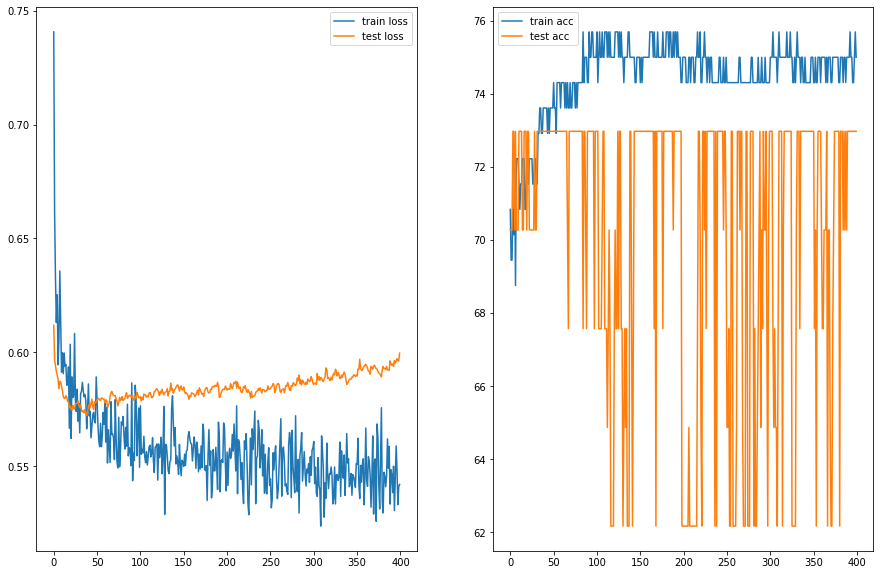

----------------------------------------
! WARNING !: Optimizer is not specified, or a declaration error occurs.
'SGD' as default, has been assigned.'
----------------------------------------
EPOCH : 1
------------------------------
TRAIN Details:
ACCURACY:  37.24  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  36 (  24.83 % )
FALSE POSITIVE:  62 (  42.76 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  36.73  %
POSITIVE PREDICTIVE VALUE(Precision):  22.50  %
NEGATIVE PREDICTIVE VALUE:  55.38  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  63.27  %
FALSE DISCOVERY RATE:  77.50  %
FALSE OMISSION RATE:  44.62  %
F1 SCORE:  28.35  %
------------------------------
TEST Details:
ACCURACY:  33.33  %
TRUE POSITIVE:   6 (  16.67 % )
TRUE NEGATIVE:   6 (  16.67 % )
FALSE POSITIVE:  19 (  52.78 % )
FALSE NEGATIVE:   5 (  13.89 % )
TRUE POSITIVE RATE(Sensitivity):  54.55  %
TRUE NEGATIVE RATE(Specific

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


EPOCH : 4
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  47 (  32.41 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  67.59  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  32.41  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY 

FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  47 (  32.41 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  67.59  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  32.41  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  30.56  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPO

TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  47 (  32.41 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  67.59  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  32.41  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  30.56  %
F1 SCORE:  0.00  %
-----------

EPOCH : 33
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  47 (  32.41 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  67.59  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  32.41  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY

TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  30.56  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPOCH : 43
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  47 (  32.41 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  67.59  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE 

EPOCH : 51
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  47 (  32.41 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  67.59  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  32.41  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY

F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  30.56  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPOCH : 59
------------------------------
TRAIN Details:
ACCURACY:  68.28  %
TRUE POSITIVE:   1 (  0.69 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  46 (  31.72 % )
TRUE POSITIVE RATE(Sensitivity):  2.13  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.06  %
FALSE 

TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.53  %
FALSE NEGATIVE RATE(Miss Rate):  95.74  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.47  %
F1 SCORE:  8.16  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  30.56  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPOCH : 68
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   4 (  2.76 % )
T

TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  43 (  29.66 % )
TRUE POSITIVE RATE(Sensitivity):  8.51  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  69.50  %
FALSE NEGATIVE RATE(Miss Rate):  91.49  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  30.50  %
F1 SCORE:  15.69  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  30.56  %
F1 SCORE:  0.00  %
----------------------------------------

FALSE DISCOVERY RATE:  50.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 86
------------------------------
TRAIN Details:
ACCURACY:  71.72  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  97 (  66.90 % )
FALSE POSITIVE:   1 (  0.69 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  14.89  %
TRUE NEGATIVE RATE(Specificity):  98.98  %
POSITIVE PREDICTIVE VALUE(Precision):  87.50  %
NEGATIVE PREDICTIVE VALUE:  70.80  %
FALSE NEGATIVE RATE(Miss Rate):  85.11  %
FALSE POSITIVE RATE(Fall-out):  1.02  %
FALSE DISCOVERY RATE:  12.50  %
FALSE OMISSION RATE:  29.20  %
F1 SCORE:  25.45  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(P

EPOCH : 95
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   8 (  5.52 % )
TRUE NEGATIVE:  94 (  64.83 % )
FALSE POSITIVE:   4 (  2.76 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  17.02  %
TRUE NEGATIVE RATE(Specificity):  95.92  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  70.68  %
FALSE NEGATIVE RATE(Miss Rate):  82.98  %
FALSE POSITIVE RATE(Fall-out):  4.08  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  29.32  %
F1 SCORE:  27.12  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVER

FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  29.32  %
F1 SCORE:  27.12  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  50.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 103
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   8 (  5.52 % )
TRUE NEGATIVE:  94 (  64.83 % )
FALSE POSITIVE:   4 (  2.76 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  17.02  %
TRUE NEGATIVE RATE(Specificity):  95.92  %
POSITIVE PREDICTIVE VALUE(

TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  38 (  26.21 % )
TRUE POSITIVE RATE(Sensitivity):  19.15  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  70.99  %
FALSE NEGATIVE RATE(Miss Rate):  80.85  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  29.01  %
F1 SCORE:  29.51  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  72.73  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  27.27  %
F1 SCORE:  28.57  %
--------------------------------------

EPOCH : 121
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   9 (  6.21 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  38 (  26.21 % )
TRUE POSITIVE RATE(Sensitivity):  19.15  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  70.99  %
FALSE NEGATIVE RATE(Miss Rate):  80.85  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  29.01  %
F1 SCORE:  29.51  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  72.73  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOV

EPOCH : 132
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   9 (  6.21 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  38 (  26.21 % )
TRUE POSITIVE RATE(Sensitivity):  19.15  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  70.99  %
FALSE NEGATIVE RATE(Miss Rate):  80.85  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  29.01  %
F1 SCORE:  29.51  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  72.73  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOV

F1 SCORE:  29.51  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  72.73  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  27.27  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 142
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   9 (  6.21 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  38 (  26.21 % )
TRUE POSITIVE RATE(Sensitivity):  19.15  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  70.99  %
FAL

EPOCH : 150
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:  10 (  6.90 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   6 (  4.14 % )
FALSE NEGATIVE:  37 (  25.52 % )
TRUE POSITIVE RATE(Sensitivity):  21.28  %
TRUE NEGATIVE RATE(Specificity):  93.88  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  71.32  %
FALSE NEGATIVE RATE(Miss Rate):  78.72  %
FALSE POSITIVE RATE(Fall-out):  6.12  %
FALSE DISCOVERY RATE:  37.50  %
FALSE OMISSION RATE:  28.68  %
F1 SCORE:  31.75  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  72.73  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOV

EPOCH : 159
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  63.16  %
NEGATIVE PREDICTIVE VALUE:  72.22  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  27.78  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOV

ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  63.16  %
NEGATIVE PREDICTIVE VALUE:  72.22  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  27.78  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCOR

EPOCH : 177
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  63.16  %
NEGATIVE PREDICTIVE VALUE:  72.22  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  27.78  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOV

EPOCH : 186
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  63.16  %
NEGATIVE PREDICTIVE VALUE:  72.22  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  27.78  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOV

TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  63.16  %
NEGATIVE PREDICTIVE VALUE:  72.22  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  27.78  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
--------------------------------------

EPOCH : 204
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  63.16  %
NEGATIVE PREDICTIVE VALUE:  72.22  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  27.78  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOV

EPOCH : 214
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  63.16  %
NEGATIVE PREDICTIVE VALUE:  72.22  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  27.78  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOV

EPOCH : 224
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  37.04  %
FALSE OMISSION RATE:  25.42  %
F1 SCORE:  45.95  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISC

------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 234
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Mi

FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  37.04  %
FALSE OMISSION RATE:  25.42  %
F1 SCORE:  45.95  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 243
------------------

TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 252
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  37.04  %
FALSE OMISSION RATE:  25.42  %
F1 SCORE:  45.95  %
------------------------------
TEST Details:
ACCU

FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  37.04  %
FALSE OMISSION RATE:  25.42  %
F1 SCORE:  45.95  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 261
------------------

ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 270
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-

TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 279
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  37.04  %
FAL

FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  37.04  %
FALSE OMISSION RATE:  25.42  %
F1 SCORE:  45.95  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 288
------------------

------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  19 (  13.10 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  28 (  19.31 % )
TRUE POSITIVE RATE(Sensitivity):  40.43  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  63.33  %
NEGATIVE PREDICTIVE VALUE:  75.65  %
FALSE NEGATIVE RATE(Miss Rate):  59.57  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  36.67  %
FALSE OMISSION RATE:  24.35  %
F1 SCORE:  49.35  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE: 

EPOCH : 306
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  37.04  %
FALSE OMISSION RATE:  25.42  %
F1 SCORE:  45.95  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISC

TRUE POSITIVE:  20 (  13.79 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  27 (  18.62 % )
TRUE POSITIVE RATE(Sensitivity):  42.55  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  64.52  %
NEGATIVE PREDICTIVE VALUE:  76.32  %
FALSE NEGATIVE RATE(Miss Rate):  57.45  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  35.48  %
FALSE OMISSION RATE:  23.68  %
F1 SCORE:  51.28  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
-----

FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 325
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  20 (  13.79 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  27 (  18.62 % )
TRUE POSITIVE RATE(Sensitivity):  42.55  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  64.52  %
NEGATIVE PREDICTIVE VALUE:  76.32  %
FALSE NEGATIVE RATE(Miss Rate):  57.45  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  35.48  %
FALSE OMISSION RATE:  23.68  %
F1 SCORE:  51.28  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   2 (  5.56 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specifi

FALSE NEGATIVE RATE(Miss Rate):  57.45  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  35.48  %
FALSE OMISSION RATE:  23.68  %
F1 SCORE:  51.28  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 335
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  20 (  13.79 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  27 (  18.62 % )
TRUE POSITIVE RATE(Sensitiv

TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  62.96  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  37.04  %
FALSE OMISSION RATE:  25.42  %
F1 SCORE:  45.95  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 345
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  18 (  12.41 

EPOCH : 353
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  75.21  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  24.79  %
F1 SCORE:  48.00  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISC

FALSE DISCOVERY RATE:  34.48  %
FALSE OMISSION RATE:  24.14  %
F1 SCORE:  50.00  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 363
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALU

ACCURACY:  73.79  %
TRUE POSITIVE:  20 (  13.79 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  27 (  18.62 % )
TRUE POSITIVE RATE(Sensitivity):  42.55  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  64.52  %
NEGATIVE PREDICTIVE VALUE:  76.32  %
FALSE NEGATIVE RATE(Miss Rate):  57.45  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  35.48  %
FALSE OMISSION RATE:  23.68  %
F1 SCORE:  51.28  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SC

FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 382
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  75.21  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  24.79  %
F1 SCORE:  48.00  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VAL

F1 SCORE:  51.28  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  40.00  %
----------------------------------------------------------------------
EPOCH : 391
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  19 (  13.10 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  28 (  19.31 % )
TRUE POSITIVE RATE(Sensitivity):  40.43  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  63.33  %
NEGATIVE PREDICTIVE VALUE:  75.65  %
FA

FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  92.00  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  74.19  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  8.00  %
FALSE DISCOVERY RATE:  40.00  %
FALSE OMISSION RATE:  25.81  %
F1 SCORE:  37.50  %
----------------------------------------------------------------------
EPOCH : 400
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  20 (  13.79 % )
TRUE NEGATIVE:  85 (  58.62 % )
FALSE POSITIVE:  13 (  8.97 % )
FALSE NEGATIVE:  27 (  18.62 % )
TRUE POSITIVE RATE(Sensitivity):  42.55  %
TRUE NEGATIVE RATE(Specificity):  86.73  %
POSITIVE PREDICTIVE VALUE(Precision):  60.61  %
NEGATIVE PREDICTIVE VALUE:  75.89  %
FALSE NEGATIVE RATE(Miss Rate):  57.45  %
FALSE POSITIVE RATE(Fall-out):  13.27  %
FALSE DISCOVERY RATE:  39.39  %
FALSE OMISSION RATE:  24.11  %
F1 SCORE:  50.00  %
----------------

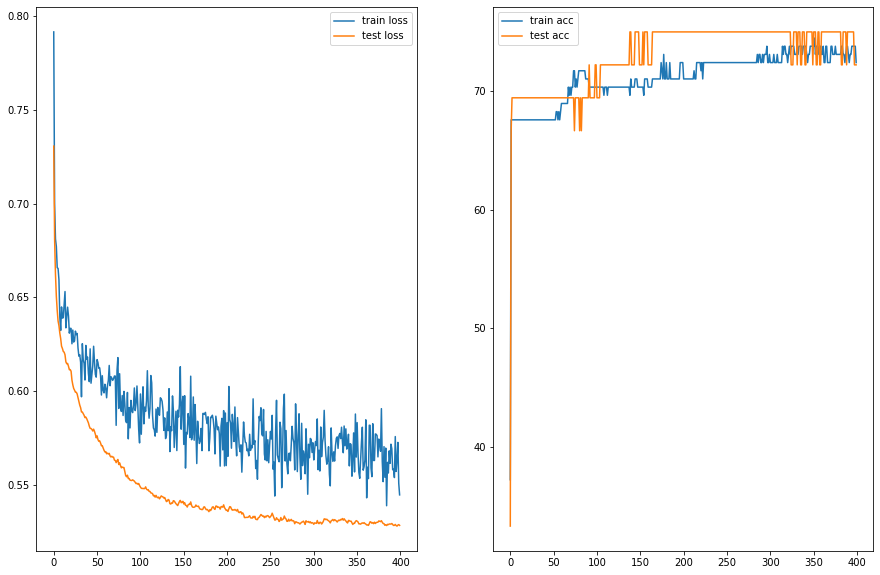

----------------------------------------
! WARNING !: Optimizer is not specified, or a declaration error occurs.
'SGD' as default, has been assigned.'
----------------------------------------
EPOCH : 1
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   3 (  2.07 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  44 (  30.34 % )
TRUE POSITIVE RATE(Sensitivity):  6.38  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  69.01  %
FALSE NEGATIVE RATE(Miss Rate):  93.62  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  30.99  %
F1 SCORE:  12.00  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity): 

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  47 (  32.41 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  67.59  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  32.41  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  30.56  %
F1 SCORE:  0.00  %
-----------

NEGATIVE PREDICTIVE VALUE:  67.59  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  32.41  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  30.56  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPOCH : 13
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  47 (  32.41 

EPOCH : 21
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  47 (  32.41 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  67.59  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  32.41  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  25 (  69.44 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  69.44  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY

FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  96.00  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  4.00  %
FALSE DISCOVERY RATE:  50.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 32
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   4 (  2.76 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  43 (  29.66 % )
TRUE POSITIVE RATE(Sensitivity):  8.51  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  69.50  %
FALSE NEGATIVE RATE(Miss Rate):  91.49  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  30.50  %
F1 SCORE:  15.69  %
--------------------

------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   2 (  5.56 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  92.00  %
POSITIVE PREDICTIVE VALUE(Precision):  33.33  %
NEGATIVE PREDICTIVE VALUE:  69.70  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  8.00  %
FALSE DISCOVERY RATE:  66.67  %
FALSE OMISSION RATE:  30.30  %
F1 SCORE:  14.29  %
----------------------------------------------------------------------
EPOCH : 42
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   5 (  3.45 % )
TRUE NEGATIVE:  97 (  66.90 % )
FALSE POSITIVE:   1 (  0.69 % )
FALSE NEGATIVE:  42 (  28.97 % )
TRUE POSITIVE RATE(Sensitivity):  10.64  %
TRUE NEGATIVE RATE(Specificity):  98.98  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  69.78  %
FALSE NEGATIVE RATE(Miss 

TRUE NEGATIVE:  97 (  66.90 % )
FALSE POSITIVE:   1 (  0.69 % )
FALSE NEGATIVE:  41 (  28.28 % )
TRUE POSITIVE RATE(Sensitivity):  12.77  %
TRUE NEGATIVE RATE(Specificity):  98.98  %
POSITIVE PREDICTIVE VALUE(Precision):  85.71  %
NEGATIVE PREDICTIVE VALUE:  70.29  %
FALSE NEGATIVE RATE(Miss Rate):  87.23  %
FALSE POSITIVE RATE(Fall-out):  1.02  %
FALSE DISCOVERY RATE:  14.29  %
FALSE OMISSION RATE:  29.71  %
F1 SCORE:  22.22  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   2 (  5.56 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  92.00  %
POSITIVE PREDICTIVE VALUE(Precision):  33.33  %
NEGATIVE PREDICTIVE VALUE:  69.70  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  8.00  %
FALSE DISCOVERY RATE:  66.67  %
FALSE OMISSION RATE:  30.30  %
F1 SCORE:  14.29  %
---------------------------------------

FALSE DISCOVERY RATE:  29.41  %
FALSE OMISSION RATE:  27.34  %
F1 SCORE:  37.50  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 60
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  11 (  7.59 % )
TRUE NEGATIVE:  95 (  65.52 % )
FALSE POSITIVE:   3 (  2.07 % )
FALSE NEGATIVE:  36 (  24.83 % )
TRUE POSITIVE RATE(Sensitivity):  23.40  %
TRUE NEGATIVE RATE(Specificity):  96.94  %
POSITIVE PREDICTIVE VALUE

FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 69
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  70.59  %
NEGATIVE PREDICTIVE VALUE:  72.66  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  29.41  %
FALSE OMISSION RATE:  27.34  %
F1 SCORE:  37.50  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specifici

FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  29.41  %
FALSE OMISSION RATE:  27.34  %
F1 SCORE:  37.50  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 78
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivit

FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 87
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  70.59  %
NEGATIVE PREDICTIVE VALUE:  72.66  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  29.41  %
FALSE OMISSION RATE:  27.34  %
F1 SCORE:  37.50  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specifici

TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 96
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  70.59  %
NEGATIVE PREDICTIVE VALUE:  72.66  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  29.41  %
FALSE

ACCURACY:  72.41  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  70.59  %
NEGATIVE PREDICTIVE VALUE:  72.66  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  29.41  %
FALSE OMISSION RATE:  27.34  %
F1 SCORE:  37.50  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCO

EPOCH : 113
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  70.59  %
NEGATIVE PREDICTIVE VALUE:  72.66  %
FALSE NEGATIVE RATE(Miss Rate):  74.47  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  29.41  %
FALSE OMISSION RATE:  27.34  %
F1 SCORE:  37.50  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCO

FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  29.41  %
FALSE OMISSION RATE:  27.34  %
F1 SCORE:  37.50  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 123
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  25.53  %
TRUE NEGATIVE RATE(Specific

TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 130
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  14 (  9.66 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  29.79  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  73.68  %
NEGATIVE PREDICTIVE VALUE:  73.81  %
FALSE NEGATIVE RATE(Miss Rate):  70.21  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  26.32  %
FALSE OMISSION RATE:  26.19  %
F1 SCORE:  42.42  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 %

FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  29.79  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  73.68  %
NEGATIVE PREDICTIVE VALUE:  73.81  %
FALSE NEGATIVE RATE(Miss Rate):  70.21  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  26.32  %
FALSE OMISSION RATE:  26.19  %
F1 SCORE:  42.42  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
---------------------------------------------------------------------

TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 148
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  14 (  9.66 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  29.79  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  73.68  %
NEGATIVE PREDICTIVE VALUE:  73.81  %
FALSE NEGATIVE RATE(Miss Rate):  70.21  %
FALSE POSIT

TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 157
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  14 (  9.66 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  29.79  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  73.68  %
NEGATIVE PREDICTIVE VALUE:  73.81  %
FALSE NEGATIVE RATE(Miss Rate):  70.21  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  26.32  %
FALSE OMISSION RATE:  26.19  %
F1 SCORE:  42.42  %
------------------------------
TEST Details:
ACCURA

FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  80.00  %
FALSE OMISSION RATE:  32.26  %
F1 SCORE:  12.50  %
----------------------------------------------------------------------
EPOCH : 166
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  14 (  9.66 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  29.79  %
TRUE NEGATIVE RATE(Specificity):  94.90  %
POSITIVE PREDICTIVE VALUE(Precision):  73.68  %
NEGATIVE PREDICTIVE VALUE:  73.81  %
FALSE NEGATIVE RATE(Miss Rate):  70.21  %
FALSE POSITIVE RATE(Fall-out):  5.10  %
FALSE DISCOVERY RATE:  26.32  %
FALSE OMISSION RATE:  26.19  %
F1 SCORE:  42.42  %
------------------

EPOCH : 174
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  15 (  10.34 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  32 (  22.07 % )
TRUE POSITIVE RATE(Sensitivity):  31.91  %
TRUE NEGATIVE RATE(Specificity):  91.84  %
POSITIVE PREDICTIVE VALUE(Precision):  65.22  %
NEGATIVE PREDICTIVE VALUE:  73.77  %
FALSE NEGATIVE RATE(Miss Rate):  68.09  %
FALSE POSITIVE RATE(Fall-out):  8.16  %
FALSE DISCOVERY RATE:  34.78  %
FALSE OMISSION RATE:  26.23  %
F1 SCORE:  42.86  %
------------------------------
TEST Details:
ACCURACY:  58.33  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  20 (  55.56 % )
FALSE POSITIVE:   5 (  13.89 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  16.67  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE DISC

EPOCH : 184
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  14 (  9.66 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   6 (  4.14 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  29.79  %
TRUE NEGATIVE RATE(Specificity):  93.88  %
POSITIVE PREDICTIVE VALUE(Precision):  70.00  %
NEGATIVE PREDICTIVE VALUE:  73.60  %
FALSE NEGATIVE RATE(Miss Rate):  70.21  %
FALSE POSITIVE RATE(Fall-out):  6.12  %
FALSE DISCOVERY RATE:  30.00  %
FALSE OMISSION RATE:  26.40  %
F1 SCORE:  41.79  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  21 (  58.33 % )
FALSE POSITIVE:   4 (  11.11 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  20.00  %
NEGATIVE PREDICTIVE VALUE:  67.74  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCO

F1 SCORE:  45.71  %
------------------------------
TEST Details:
ACCURACY:  55.56  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  19 (  52.78 % )
FALSE POSITIVE:   6 (  16.67 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  14.29  %
NEGATIVE PREDICTIVE VALUE:  65.52  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  85.71  %
FALSE OMISSION RATE:  34.48  %
F1 SCORE:  11.11  %
----------------------------------------------------------------------
EPOCH : 195
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  14 (  9.66 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   6 (  4.14 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  29.79  %
TRUE NEGATIVE RATE(Specificity):  93.88  %
POSITIVE PREDICTIVE VALUE(Precision):  70.00  %
NEGATIVE PREDICTIVE VALUE:  73.60  %
FA

TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  28.57  %
NEGATIVE PREDICTIVE VALUE:  68.97  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE DISCOVERY RATE:  71.43  %
FALSE OMISSION RATE:  31.03  %
F1 SCORE:  22.22  %
----------------------------------------------------------------------
EPOCH : 204
------------------------------
TRAIN Details:
ACCURACY:  74.48  %
TRUE POSITIVE:  16 (  11.03 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   6 (  4.14 % )
FALSE NEGATIVE:  31 (  21.38 % )
TRUE POSITIVE RATE(Sensitivity):  34.04  %
TRUE NEGATIVE RATE(Specificity):  93.88  %
POSITIVE PREDICTIVE VALUE(Precision):  72.73  %
NEGATIVE PREDICTIVE VALUE:  74.80  %
FALSE NEGATIVE RATE(Miss Rate):  65.96  %
FALSE POSITIVE RATE(Fall-out):  6.12  %
FALSE DISCOVERY RATE:  27.27  %
FALSE OMISSION RATE:  25.20  %
F1 SCORE:  46.38  %
------------------------------
TEST Details:
ACCU

TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  69.57  %
NEGATIVE PREDICTIVE VALUE:  74.59  %
FALSE NEGATIVE RATE(Miss Rate):  65.96  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  30.43  %
FALSE OMISSION RATE:  25.41  %
F1 SCORE:  45.71  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  20 (  55.56 % )
FALSE POSITIVE:   5 (  13.89 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  28.57  %
NEGATIVE PREDICTIVE VALUE:  68.97  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE DISCOVERY RATE:  71.43  %
FALSE OMISSION RATE:  31.03  %
F1 SCORE:  22.22  %
----------------------------------------------------------------------
EPOCH : 213
------------------------------
TRAIN Details:
ACCURACY:  74.48  %
TRUE POSITIVE:  17 (  11.72

FALSE OMISSION RATE:  25.20  %
F1 SCORE:  46.38  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  20 (  55.56 % )
FALSE POSITIVE:   5 (  13.89 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  28.57  %
NEGATIVE PREDICTIVE VALUE:  68.97  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE DISCOVERY RATE:  71.43  %
FALSE OMISSION RATE:  31.03  %
F1 SCORE:  22.22  %
----------------------------------------------------------------------
EPOCH : 222
------------------------------
TRAIN Details:
ACCURACY:  74.48  %
TRUE POSITIVE:  16 (  11.03 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   6 (  4.14 % )
FALSE NEGATIVE:  31 (  21.38 % )
TRUE POSITIVE RATE(Sensitivity):  34.04  %
TRUE NEGATIVE RATE(Specificity):  93.88  %
POSITIVE PREDICTIVE VALUE(Precision):  72.73  %
NEGATI

FALSE POSITIVE RATE(Fall-out):  6.12  %
FALSE DISCOVERY RATE:  27.27  %
FALSE OMISSION RATE:  25.20  %
F1 SCORE:  46.38  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  20 (  55.56 % )
FALSE POSITIVE:   5 (  13.89 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  28.57  %
NEGATIVE PREDICTIVE VALUE:  68.97  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE DISCOVERY RATE:  71.43  %
FALSE OMISSION RATE:  31.03  %
F1 SCORE:  22.22  %
----------------------------------------------------------------------
EPOCH : 232
------------------------------
TRAIN Details:
ACCURACY:  74.48  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specif

EPOCH : 242
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  91.84  %
POSITIVE PREDICTIVE VALUE(Precision):  68.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  8.16  %
FALSE DISCOVERY RATE:  32.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  47.22  %
------------------------------
TEST Details:
ACCURACY:  55.56  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  19 (  52.78 % )
FALSE POSITIVE:   6 (  16.67 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  9.09  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  14.29  %
NEGATIVE PREDICTIVE VALUE:  65.52  %
FALSE NEGATIVE RATE(Miss Rate):  90.91  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISC

EPOCH : 252
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  19 (  13.10 % )
TRUE NEGATIVE:  86 (  59.31 % )
FALSE POSITIVE:  12 (  8.28 % )
FALSE NEGATIVE:  28 (  19.31 % )
TRUE POSITIVE RATE(Sensitivity):  40.43  %
TRUE NEGATIVE RATE(Specificity):  87.76  %
POSITIVE PREDICTIVE VALUE(Precision):  61.29  %
NEGATIVE PREDICTIVE VALUE:  75.44  %
FALSE NEGATIVE RATE(Miss Rate):  59.57  %
FALSE POSITIVE RATE(Fall-out):  12.24  %
FALSE DISCOVERY RATE:  38.71  %
FALSE OMISSION RATE:  24.56  %
F1 SCORE:  48.72  %
------------------------------
TEST Details:
ACCURACY:  55.56  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  18 (  50.00 % )
FALSE POSITIVE:   7 (  19.44 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  22.22  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE DI

TEST Details:
ACCURACY:  55.56  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  18 (  50.00 % )
FALSE POSITIVE:   7 (  19.44 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  22.22  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE DISCOVERY RATE:  77.78  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  20.00  %
----------------------------------------------------------------------
EPOCH : 262
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  62.07  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POS

EPOCH : 271
------------------------------
TRAIN Details:
ACCURACY:  74.48  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  36.17  %
TRUE NEGATIVE RATE(Specificity):  92.86  %
POSITIVE PREDICTIVE VALUE(Precision):  70.83  %
NEGATIVE PREDICTIVE VALUE:  75.21  %
FALSE NEGATIVE RATE(Miss Rate):  63.83  %
FALSE POSITIVE RATE(Fall-out):  7.14  %
FALSE DISCOVERY RATE:  29.17  %
FALSE OMISSION RATE:  24.79  %
F1 SCORE:  47.89  %
------------------------------
TEST Details:
ACCURACY:  61.11  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  20 (  55.56 % )
FALSE POSITIVE:   5 (  13.89 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  28.57  %
NEGATIVE PREDICTIVE VALUE:  68.97  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE DIS

TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  91.84  %
POSITIVE PREDICTIVE VALUE(Precision):  69.23  %
NEGATIVE PREDICTIVE VALUE:  75.63  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  8.16  %
FALSE DISCOVERY RATE:  30.77  %
FALSE OMISSION RATE:  24.37  %
F1 SCORE:  49.32  %
------------------------------
TEST Details:
ACCURACY:  58.33  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  19 (  52.78 % )
FALSE POSITIVE:   6 (  16.67 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  67.86  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  75.00  %
FALSE OMISSION RATE:  32.14  %
F1 SCORE:  21.05  %
------------------------------------

ACCURACY:  73.10  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  75.21  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  24.79  %
F1 SCORE:  48.00  %
------------------------------
TEST Details:
ACCURACY:  55.56  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  18 (  50.00 % )
FALSE POSITIVE:   7 (  19.44 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  22.22  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE DISCOVERY RATE:  77.78  %
FALSE OMISSION RATE:  33.33  %
F1 

EPOCH : 299
------------------------------
TRAIN Details:
ACCURACY:  72.41  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  88.78  %
POSITIVE PREDICTIVE VALUE(Precision):  62.07  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  11.22  %
FALSE DISCOVERY RATE:  37.93  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  47.37  %
------------------------------
TEST Details:
ACCURACY:  55.56  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  18 (  50.00 % )
FALSE POSITIVE:   7 (  19.44 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  22.22  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE DI

------------------------------
TEST Details:
ACCURACY:  58.33  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  19 (  52.78 % )
FALSE POSITIVE:   6 (  16.67 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  67.86  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  75.00  %
FALSE OMISSION RATE:  32.14  %
F1 SCORE:  21.05  %
----------------------------------------------------------------------
EPOCH : 310
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  89 (  61.38 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  90.82  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  75.42  %
FALSE NEGATIVE RATE(

POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  67.86  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  75.00  %
FALSE OMISSION RATE:  32.14  %
F1 SCORE:  21.05  %
----------------------------------------------------------------------
EPOCH : 319
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  89 (  61.38 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  90.82  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  75.42  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  9.18  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  24.58  %
F1 SCORE:  48.65  %
------------------------------
TEST Details:
ACCURACY:  58.33  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  19 (  52.78 % )
FALSE P

ACCURACY:  73.10  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  75.21  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  24.79  %
F1 SCORE:  48.00  %
------------------------------
TEST Details:
ACCURACY:  58.33  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  19 (  52.78 % )
FALSE POSITIVE:   6 (  16.67 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  67.86  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  75.00  %
FALSE OMISSION RATE:  32.14  %
F1 

FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  24.79  %
F1 SCORE:  48.00  %
------------------------------
TEST Details:
ACCURACY:  58.33  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  19 (  52.78 % )
FALSE POSITIVE:   6 (  16.67 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  67.86  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  75.00  %
FALSE OMISSION RATE:  32.14  %
F1 SCORE:  21.05  %
----------------------------------------------------------------------
EPOCH : 337
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  20 (  13.79 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  27 (  18.62 % )
TRUE POSITIVE RATE(Sensit

F1 SCORE:  50.00  %
------------------------------
TEST Details:
ACCURACY:  55.56  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  18 (  50.00 % )
FALSE POSITIVE:   7 (  19.44 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  22.22  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE DISCOVERY RATE:  77.78  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  20.00  %
----------------------------------------------------------------------
EPOCH : 346
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  22 (  15.17 % )
TRUE NEGATIVE:  84 (  57.93 % )
FALSE POSITIVE:  14 (  9.66 % )
FALSE NEGATIVE:  25 (  17.24 % )
TRUE POSITIVE RATE(Sensitivity):  46.81  %
TRUE NEGATIVE RATE(Specificity):  85.71  %
POSITIVE PREDICTIVE VALUE(Precision):  61.11  %
NEGATIVE PREDICTIVE VALUE:  77.06  %


TRUE POSITIVE RATE(Sensitivity):  40.43  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  65.52  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  59.57  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  34.48  %
FALSE OMISSION RATE:  24.14  %
F1 SCORE:  50.00  %
------------------------------
TEST Details:
ACCURACY:  55.56  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  18 (  50.00 % )
FALSE POSITIVE:   7 (  19.44 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  22.22  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE DISCOVERY RATE:  77.78  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  20.00  %
----------------------------------------------------------------------
EPOCH : 355
------------------------------
TRAIN Details:
ACC

F1 SCORE:  48.00  %
------------------------------
TEST Details:
ACCURACY:  58.33  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  19 (  52.78 % )
FALSE POSITIVE:   6 (  16.67 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  67.86  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  75.00  %
FALSE OMISSION RATE:  32.14  %
F1 SCORE:  21.05  %
----------------------------------------------------------------------
EPOCH : 364
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  75.21  %


TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  67.86  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  75.00  %
FALSE OMISSION RATE:  32.14  %
F1 SCORE:  21.05  %
----------------------------------------------------------------------
EPOCH : 374
------------------------------
TRAIN Details:
ACCURACY:  73.10  %
TRUE POSITIVE:  18 (  12.41 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  38.30  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  75.21  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  24.79  %
F1 SCORE:  48.00  %
------------------------------
TEST Details:
ACC

TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  64.29  %
NEGATIVE PREDICTIVE VALUE:  75.21  %
FALSE NEGATIVE RATE(Miss Rate):  61.70  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  35.71  %
FALSE OMISSION RATE:  24.79  %
F1 SCORE:  48.00  %
------------------------------
TEST Details:
ACCURACY:  58.33  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  19 (  52.78 % )
FALSE POSITIVE:   6 (  16.67 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  67.86  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  75.00  %
FALSE OMISSION RATE:  32.14  %
F1 SCORE:  21.05  %
----------------------------------------------------------------------
EPOCH : 383
------------------------------
TRAIN Details:
ACCURACY:  73.79  %
TRUE POSITIVE:  18 (  12.4

TRUE NEGATIVE:  18 (  50.00 % )
FALSE POSITIVE:   7 (  19.44 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  72.00  %
POSITIVE PREDICTIVE VALUE(Precision):  22.22  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  28.00  %
FALSE DISCOVERY RATE:  77.78  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  20.00  %
----------------------------------------------------------------------
EPOCH : 392
------------------------------
TRAIN Details:
ACCURACY:  74.48  %
TRUE POSITIVE:  20 (  13.79 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  27 (  18.62 % )
TRUE POSITIVE RATE(Sensitivity):  42.55  %
TRUE NEGATIVE RATE(Specificity):  89.80  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  76.52  %
FALSE NEGATIVE RATE(Miss Rate):  57.45  %
FALSE POSITIVE RATE(Fall-out):  10.20  %
FALSE DISCOVERY RATE:  33.33  %
F

TRUE NEGATIVE RATE(Specificity):  76.00  %
POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  67.86  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  24.00  %
FALSE DISCOVERY RATE:  75.00  %
FALSE OMISSION RATE:  32.14  %
F1 SCORE:  21.05  %


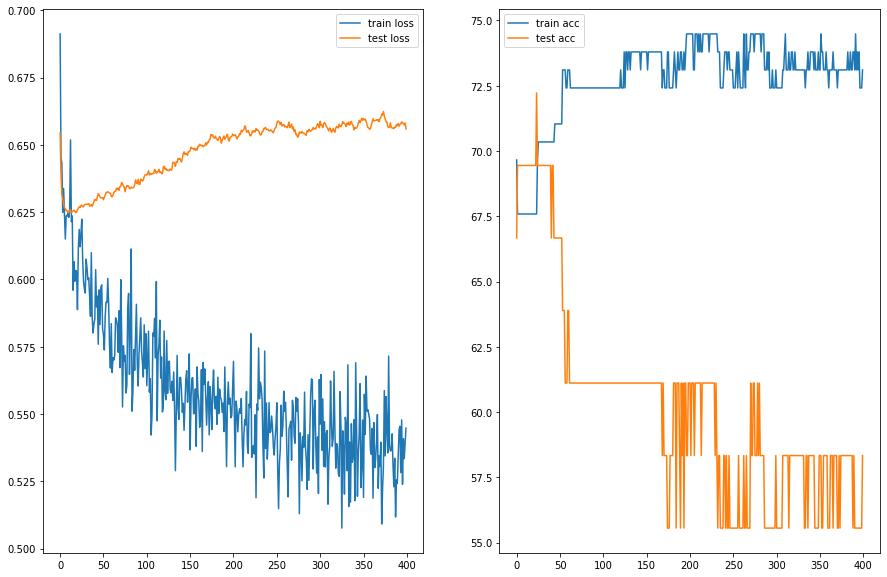

----------------------------------------
! WARNING !: Optimizer is not specified, or a declaration error occurs.
'SGD' as default, has been assigned.'
----------------------------------------
EPOCH : 1
------------------------------
TRAIN Details:
ACCURACY:  68.28  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  99 (  68.28 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  46 (  31.72 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  68.28  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  31.72  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  1

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  99 (  68.28 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  46 (  31.72 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  68.28  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  31.72  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  0.00  %
----------

FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  46 (  31.72 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  68.28  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  31.72  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPO

ACCURACY:  68.28  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  99 (  68.28 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  46 (  31.72 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  68.28  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  31.72  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE: 

FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  46 (  31.72 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  68.28  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  31.72  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPO

ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPOCH : 40
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   2 (  1.38 % )
TRUE NEGATIVE:  99 (  68.28 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  44 (  30.34 % )
TRUE POSITIVE RATE(Sensitivity):  4.35  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  69.23  %
FALSE NEGATIVE RATE(Miss Rate):  95.65  %
FALSE POSITIVE RATE(Fall-out

FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  44 (  30.34 % )
TRUE POSITIVE RATE(Sensitivity):  4.35  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  69.23  %
FALSE NEGATIVE RATE(Miss Rate):  95.65  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  30.77  %
F1 SCORE:  8.33  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EP

EPOCH : 58
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   2 (  1.38 % )
TRUE NEGATIVE:  99 (  68.28 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  44 (  30.34 % )
TRUE POSITIVE RATE(Sensitivity):  4.35  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  69.23  %
FALSE NEGATIVE RATE(Miss Rate):  95.65  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  30.77  %
F1 SCORE:  8.33  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVER

POSITIVE PREDICTIVE VALUE(Precision):  0.00  %
NEGATIVE PREDICTIVE VALUE:  65.71  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  100.00  %
FALSE OMISSION RATE:  34.29  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPOCH : 66
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   4 (  2.76 % )
TRUE NEGATIVE:  97 (  66.90 % )
FALSE POSITIVE:   2 (  1.38 % )
FALSE NEGATIVE:  42 (  28.97 % )
TRUE POSITIVE RATE(Sensitivity):  8.70  %
TRUE NEGATIVE RATE(Specificity):  97.98  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  69.78  %
FALSE NEGATIVE RATE(Miss Rate):  91.30  %
FALSE POSITIVE RATE(Fall-out):  2.02  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  30.22  %
F1 SCORE:  15.38  %
------------------------------
TEST Details:
ACCURACY:  63.89  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSIT

FALSE OMISSION RATE:  30.22  %
F1 SCORE:  15.38  %
------------------------------
TEST Details:
ACCURACY:  63.89  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  0.00  %
NEGATIVE PREDICTIVE VALUE:  65.71  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  100.00  %
FALSE OMISSION RATE:  34.29  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPOCH : 75
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   4 (  2.76 % )
TRUE NEGATIVE:  97 (  66.90 % )
FALSE POSITIVE:   2 (  1.38 % )
FALSE NEGATIVE:  42 (  28.97 % )
TRUE POSITIVE RATE(Sensitivity):  8.70  %
TRUE NEGATIVE RATE(Specificity):  97.98  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PRE

ACCURACY:  69.66  %
TRUE POSITIVE:   5 (  3.45 % )
TRUE NEGATIVE:  96 (  66.21 % )
FALSE POSITIVE:   3 (  2.07 % )
FALSE NEGATIVE:  41 (  28.28 % )
TRUE POSITIVE RATE(Sensitivity):  10.87  %
TRUE NEGATIVE RATE(Specificity):  96.97  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  70.07  %
FALSE NEGATIVE RATE(Miss Rate):  89.13  %
FALSE POSITIVE RATE(Fall-out):  3.03  %
FALSE DISCOVERY RATE:  37.50  %
FALSE OMISSION RATE:  29.93  %
F1 SCORE:  18.52  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  67.65  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  50.00  %
FALSE OMISSION RATE:  32.35  %
F1 SCORE

FALSE DISCOVERY RATE:  37.50  %
FALSE OMISSION RATE:  29.93  %
F1 SCORE:  18.52  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  69.70  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  30.30  %
F1 SCORE:  26.67  %
----------------------------------------------------------------------
EPOCH : 92
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   5 (  3.45 % )
TRUE NEGATIVE:  96 (  66.21 % )
FALSE POSITIVE:   3 (  2.07 % )
FALSE NEGATIVE:  41 (  28.28 % )
TRUE POSITIVE RATE(Sensitivity):  10.87  %
TRUE NEGATIVE RATE(Specificity):  96.97  %
POSITIVE PREDICTIVE VALUE(

POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  69.70  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  30.30  %
F1 SCORE:  26.67  %
----------------------------------------------------------------------
EPOCH : 101
------------------------------
TRAIN Details:
ACCURACY:  68.97  %
TRUE POSITIVE:   5 (  3.45 % )
TRUE NEGATIVE:  95 (  65.52 % )
FALSE POSITIVE:   4 (  2.76 % )
FALSE NEGATIVE:  41 (  28.28 % )
TRUE POSITIVE RATE(Sensitivity):  10.87  %
TRUE NEGATIVE RATE(Specificity):  95.96  %
POSITIVE PREDICTIVE VALUE(Precision):  55.56  %
NEGATIVE PREDICTIVE VALUE:  69.85  %
FALSE NEGATIVE RATE(Miss Rate):  89.13  %
FALSE POSITIVE RATE(Fall-out):  4.04  %
FALSE DISCOVERY RATE:  44.44  %
FALSE OMISSION RATE:  30.15  %
F1 SCORE:  18.18  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POS

ACCURACY:  69.66  %
TRUE POSITIVE:   5 (  3.45 % )
TRUE NEGATIVE:  96 (  66.21 % )
FALSE POSITIVE:   3 (  2.07 % )
FALSE NEGATIVE:  41 (  28.28 % )
TRUE POSITIVE RATE(Sensitivity):  10.87  %
TRUE NEGATIVE RATE(Specificity):  96.97  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  70.07  %
FALSE NEGATIVE RATE(Miss Rate):  89.13  %
FALSE POSITIVE RATE(Fall-out):  3.03  %
FALSE DISCOVERY RATE:  37.50  %
FALSE OMISSION RATE:  29.93  %
F1 SCORE:  18.52  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  69.70  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  30.30  %
F1 SCOR

FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  95.96  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  70.37  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  4.04  %
FALSE DISCOVERY RATE:  40.00  %
FALSE OMISSION RATE:  29.63  %
F1 SCORE:  21.43  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  25.00  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  71.88  %
FALSE NEGATIVE RATE(Miss Rate):  75.00  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  28.12  %
F1 SCORE:  37.50  %
----------------------------------------------------------------------
EPOCH : 119
-------------------

POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  71.88  %
FALSE NEGATIVE RATE(Miss Rate):  75.00  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  28.12  %
F1 SCORE:  37.50  %
----------------------------------------------------------------------
EPOCH : 128
------------------------------
TRAIN Details:
ACCURACY:  68.97  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  94 (  64.83 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  94.95  %
POSITIVE PREDICTIVE VALUE(Precision):  54.55  %
NEGATIVE PREDICTIVE VALUE:  70.15  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  5.05  %
FALSE DISCOVERY RATE:  45.45  %
FALSE OMISSION RATE:  29.85  %
F1 SCORE:  21.05  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POS

FALSE DISCOVERY RATE:  40.00  %
FALSE OMISSION RATE:  29.63  %
F1 SCORE:  21.43  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  69.70  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  30.30  %
F1 SCORE:  26.67  %
----------------------------------------------------------------------
EPOCH : 137
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  95 (  65.52 % )
FALSE POSITIVE:   4 (  2.76 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  95.96  %
POSITIVE PREDICTIVE VALUE

TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  71.88  %
FALSE NEGATIVE RATE(Miss Rate):  75.00  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  28.12  %
F1 SCORE:  37.50  %
----------------------------------------------------------------------
EPOCH : 146
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   8 (  5.52 % )
TRUE NEGATIVE:  94 (  64.83 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  38 (  26.21 % )
TRUE POSITIVE RATE(Sensitivity):  17.39  %
TRUE NEGATIVE RATE(Specificity):  94.95  %
POSITIVE PREDICTIVE VALUE(Precision):  61.54  %
NEGATIVE PREDICTIVE VALUE:  71.21  %
FALSE NEGATIVE RATE(Miss Rate):  82.61  %
FALSE POSITIVE RATE(Fall-out):  5.05  %
FALSE DISCOVERY RATE:  38.46  %
FALSE OMISSION RATE:  28.79  %
F1 SCORE:  27.12  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   3 (  8.33 % 

POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  71.88  %
FALSE NEGATIVE RATE(Miss Rate):  75.00  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  28.12  %
F1 SCORE:  37.50  %
----------------------------------------------------------------------
EPOCH : 155
------------------------------
TRAIN Details:
ACCURACY:  68.97  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  94 (  64.83 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  94.95  %
POSITIVE PREDICTIVE VALUE(Precision):  54.55  %
NEGATIVE PREDICTIVE VALUE:  70.15  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  5.05  %
FALSE DISCOVERY RATE:  45.45  %
FALSE OMISSION RATE:  29.85  %
F1 SCORE:  21.05  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POS

F1 SCORE:  24.14  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   3 (  8.33 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   9 (  25.00 % )
TRUE POSITIVE RATE(Sensitivity):  25.00  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  71.88  %
FALSE NEGATIVE RATE(Miss Rate):  75.00  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  28.12  %
F1 SCORE:  37.50  %
----------------------------------------------------------------------
EPOCH : 164
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   8 (  5.52 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   6 (  4.14 % )
FALSE NEGATIVE:  38 (  26.21 % )
TRUE POSITIVE RATE(Sensitivity):  17.39  %
TRUE NEGATIVE RATE(Specificity):  93.94  %
POSITIVE PREDICTIVE VALUE(Precision):  57.14  %
NEGATIVE PREDICTIVE VALUE:  70.99  %
FAL

FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  26.98  %
F1 SCORE:  36.92  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   4 (  11.11 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  33.33  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  80.00  %
NEGATIVE PREDICTIVE VALUE:  74.19  %
FALSE NEGATIVE RATE(Miss Rate):  66.67  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  20.00  %
FALSE OMISSION RATE:  25.81  %
F1 SCORE:  47.06  %
----------------------------------------------------------------------
EPOCH : 174
------------------------------
TRAIN Details:
ACCURACY:  71.72  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  34 (  23.45 % )
TRUE POSITIVE RATE(Sensitivity):  26.09  %
TRUE NEGATIVE RATE(Specificity):  92.93  %
POSITIVE PREDICTIVE VALU

NEGATIVE PREDICTIVE VALUE:  73.02  %
FALSE NEGATIVE RATE(Miss Rate):  73.91  %
FALSE POSITIVE RATE(Fall-out):  7.07  %
FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  26.98  %
F1 SCORE:  36.92  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 183
------------------------------
TRAIN Details:
ACCURACY:  71.72  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  34 (  2

EPOCH : 192
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  11 (  7.59 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  23.91  %
TRUE NEGATIVE RATE(Specificity):  92.93  %
POSITIVE PREDICTIVE VALUE(Precision):  61.11  %
NEGATIVE PREDICTIVE VALUE:  72.44  %
FALSE NEGATIVE RATE(Miss Rate):  76.09  %
FALSE POSITIVE RATE(Fall-out):  7.07  %
FALSE DISCOVERY RATE:  38.89  %
FALSE OMISSION RATE:  27.56  %
F1 SCORE:  34.38  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   4 (  11.11 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   8 (  22.22 % )
TRUE POSITIVE RATE(Sensitivity):  33.33  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  80.00  %
NEGATIVE PREDICTIVE VALUE:  74.19  %
FALSE NEGATIVE RATE(Miss Rate):  66.67  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCO

FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 202
------------------------------
TRAIN Details:
ACCURACY:  71.72  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  34 (  23.45 % )
TRUE POSITIVE RATE(Sensitivity):  26.09  %
TRUE NEGATIVE RATE(Specificity):  92.93  %
POSITIVE PREDICTIVE VALUE(Precision):  63.16  %
NEGATIVE PREDICTIVE VALUE:  73.02  %
FALSE NEGATIVE RATE(Miss Rate):  73.91  %
FALSE POSITIVE RATE(Fall-out):  7.07  %
FALSE DISCOVERY RATE:  36.84  %
FALSE OMISSION RATE:  26.98  %
F1 SCORE:  36.92  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specific

TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  34 (  23.45 % )
TRUE POSITIVE RATE(Sensitivity):  26.09  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  72.80  %
FALSE NEGATIVE RATE(Miss Rate):  73.91  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  40.00  %
FALSE OMISSION RATE:  27.20  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  

TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 220
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  10 (  6.90 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   6 (  4.14 % )
FALSE NEGATIVE:  36 (  24.83 % )
TRUE POSITIVE RATE(Sensitivity):  21.74  %
TRUE NEGATIVE RATE(Specificity):  93.94  %
POSITIVE PREDICTIVE VALUE(Precision):  62.50  %
NEGATIVE PREDICTIVE VALUE:  72.09  %
FALSE NEGATIVE RATE(Miss Rate):  78.26  %
FALSE POSITIVE RATE(Fall-out):  6.06  %
FALSE DISCOVERY RATE:  37.50  %
FALSE

TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  72.80  %
FALSE NEGATIVE RATE(Miss Rate):  73.91  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  40.00  %
FALSE OMISSION RATE:  27.20  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 229
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 %

FALSE OMISSION RATE:  28.35  %
F1 SCORE:  31.25  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 239
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:  10 (  6.90 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  36 (  24.83 % )
TRUE POSITIVE RATE(Sensitivity):  21.74  %
TRUE NEGATIVE RATE(Specificity):  92.93  %
POSITIVE PREDICTIVE VALUE(Precision):  58.82  %
NEGATIVE

POSITIVE PREDICTIVE VALUE(Precision):  57.89  %
NEGATIVE PREDICTIVE VALUE:  72.22  %
FALSE NEGATIVE RATE(Miss Rate):  76.09  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  42.11  %
FALSE OMISSION RATE:  27.78  %
F1 SCORE:  33.85  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 248
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:  11 (  7.59 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE PO

----------------------------------------------------------------------
EPOCH : 257
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  13 (  8.97 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  28.26  %
TRUE NEGATIVE RATE(Specificity):  90.91  %
POSITIVE PREDICTIVE VALUE(Precision):  59.09  %
NEGATIVE PREDICTIVE VALUE:  73.17  %
FALSE NEGATIVE RATE(Miss Rate):  71.74  %
FALSE POSITIVE RATE(Fall-out):  9.09  %
FALSE DISCOVERY RATE:  40.91  %
FALSE OMISSION RATE:  26.83  %
F1 SCORE:  38.24  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Mi

------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 266
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  34 (  23.45 % )
TRUE POSITIVE RATE(Sensitivity):  26.09  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  72.80  %
FALSE NEGATIVE RATE(Mi

TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 275
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  34 (  23.45 % )
TRUE POSITIVE RATE(Sensitivity):  26.09  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  72.80  %
FALSE NEGATIVE RATE(Miss Rate):  73.91  %
FALSE POSIT

EPOCH : 285
------------------------------
TRAIN Details:
ACCURACY:  71.72  %
TRUE POSITIVE:  13 (  8.97 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  28.26  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  61.90  %
NEGATIVE PREDICTIVE VALUE:  73.39  %
FALSE NEGATIVE RATE(Miss Rate):  71.74  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  38.10  %
FALSE OMISSION RATE:  26.61  %
F1 SCORE:  38.81  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCO

FALSE NEGATIVE:  32 (  22.07 % )
TRUE POSITIVE RATE(Sensitivity):  30.43  %
TRUE NEGATIVE RATE(Specificity):  89.90  %
POSITIVE PREDICTIVE VALUE(Precision):  58.33  %
NEGATIVE PREDICTIVE VALUE:  73.55  %
FALSE NEGATIVE RATE(Miss Rate):  69.57  %
FALSE POSITIVE RATE(Fall-out):  10.10  %
FALSE DISCOVERY RATE:  41.67  %
FALSE OMISSION RATE:  26.45  %
F1 SCORE:  40.00  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 296
-----------------

EPOCH : 306
------------------------------
TRAIN Details:
ACCURACY:  71.72  %
TRUE POSITIVE:  13 (  8.97 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  28.26  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  61.90  %
NEGATIVE PREDICTIVE VALUE:  73.39  %
FALSE NEGATIVE RATE(Miss Rate):  71.74  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  38.10  %
FALSE OMISSION RATE:  26.61  %
F1 SCORE:  38.81  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCO

NEGATIVE PREDICTIVE VALUE:  73.39  %
FALSE NEGATIVE RATE(Miss Rate):  71.74  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  38.10  %
FALSE OMISSION RATE:  26.61  %
F1 SCORE:  38.81  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 314
------------------------------
TRAIN Details:
ACCURACY:  71.72  %
TRUE POSITIVE:  13 (  8.97 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  33 (  2

TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  34.78  %
TRUE NEGATIVE RATE(Specificity):  88.89  %
POSITIVE PREDICTIVE VALUE(Precision):  59.26  %
NEGATIVE PREDICTIVE VALUE:  74.58  %
FALSE NEGATIVE RATE(Miss Rate):  65.22  %
FALSE POSITIVE RATE(Fall-out):  11.11  %
FALSE DISCOVERY RATE:  40.74  %
FALSE OMISSION RATE:  25.42  %
F1 SCORE:  43.84  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  22 (  61.11 % )
FALSE POSITIVE:   2 (  5.56 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  91.67  %
POSITIVE PREDICTIVE VALUE(Precision):  71.43  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  8.33  %
FALSE DISCOVERY RATE:  28.57  %
FALSE OMISSION RATE:  24.14  %
F1 SCORE:  52.63  %
------------------------------------

EPOCH : 333
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  14 (  9.66 % )
TRUE NEGATIVE:  89 (  61.38 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  32 (  22.07 % )
TRUE POSITIVE RATE(Sensitivity):  30.43  %
TRUE NEGATIVE RATE(Specificity):  89.90  %
POSITIVE PREDICTIVE VALUE(Precision):  58.33  %
NEGATIVE PREDICTIVE VALUE:  73.55  %
FALSE NEGATIVE RATE(Miss Rate):  69.57  %
FALSE POSITIVE RATE(Fall-out):  10.10  %
FALSE DISCOVERY RATE:  41.67  %
FALSE OMISSION RATE:  26.45  %
F1 SCORE:  40.00  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  22 (  61.11 % )
FALSE POSITIVE:   2 (  5.56 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  91.67  %
POSITIVE PREDICTIVE VALUE(Precision):  71.43  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  8.33  %
FALSE DISC

EPOCH : 343
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:  16 (  11.03 % )
TRUE NEGATIVE:  85 (  58.62 % )
FALSE POSITIVE:  14 (  9.66 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  34.78  %
TRUE NEGATIVE RATE(Specificity):  85.86  %
POSITIVE PREDICTIVE VALUE(Precision):  53.33  %
NEGATIVE PREDICTIVE VALUE:  73.91  %
FALSE NEGATIVE RATE(Miss Rate):  65.22  %
FALSE POSITIVE RATE(Fall-out):  14.14  %
FALSE DISCOVERY RATE:  46.67  %
FALSE OMISSION RATE:  26.09  %
F1 SCORE:  42.11  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  22 (  61.11 % )
FALSE POSITIVE:   2 (  5.56 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  91.67  %
POSITIVE PREDICTIVE VALUE(Precision):  71.43  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  8.33  %
FALSE DIS

TRUE POSITIVE:  12 (  8.28 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  34 (  23.45 % )
TRUE POSITIVE RATE(Sensitivity):  26.09  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  72.80  %
FALSE NEGATIVE RATE(Miss Rate):  73.91  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  40.00  %
FALSE OMISSION RATE:  27.20  %
F1 SCORE:  36.36  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
------

FALSE NEGATIVE:  33 (  22.76 % )
TRUE POSITIVE RATE(Sensitivity):  28.26  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  61.90  %
NEGATIVE PREDICTIVE VALUE:  73.39  %
FALSE NEGATIVE RATE(Miss Rate):  71.74  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  38.10  %
FALSE OMISSION RATE:  26.61  %
F1 SCORE:  38.81  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  23 (  63.89 % )
FALSE POSITIVE:   1 (  2.78 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  95.83  %
POSITIVE PREDICTIVE VALUE(Precision):  83.33  %
NEGATIVE PREDICTIVE VALUE:  76.67  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  4.17  %
FALSE DISCOVERY RATE:  16.67  %
FALSE OMISSION RATE:  23.33  %
F1 SCORE:  55.56  %
----------------------------------------------------------------------
EPOCH : 363
------------------

F1 SCORE:  42.67  %
------------------------------
TEST Details:
ACCURACY:  75.00  %
TRUE POSITIVE:   5 (  13.89 % )
TRUE NEGATIVE:  22 (  61.11 % )
FALSE POSITIVE:   2 (  5.56 % )
FALSE NEGATIVE:   7 (  19.44 % )
TRUE POSITIVE RATE(Sensitivity):  41.67  %
TRUE NEGATIVE RATE(Specificity):  91.67  %
POSITIVE PREDICTIVE VALUE(Precision):  71.43  %
NEGATIVE PREDICTIVE VALUE:  75.86  %
FALSE NEGATIVE RATE(Miss Rate):  58.33  %
FALSE POSITIVE RATE(Fall-out):  8.33  %
FALSE DISCOVERY RATE:  28.57  %
FALSE OMISSION RATE:  24.14  %
F1 SCORE:  52.63  %
----------------------------------------------------------------------
EPOCH : 373
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  15 (  10.34 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  31 (  21.38 % )
TRUE POSITIVE RATE(Sensitivity):  32.61  %
TRUE NEGATIVE RATE(Specificity):  88.89  %
POSITIVE PREDICTIVE VALUE(Precision):  57.69  %
NEGATIVE PREDICTIVE VALUE:  73.95  %
F

EPOCH : 381
------------------------------
TRAIN Details:
ACCURACY:  71.72  %
TRUE POSITIVE:  17 (  11.72 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  12 (  8.28 % )
FALSE NEGATIVE:  29 (  20.00 % )
TRUE POSITIVE RATE(Sensitivity):  36.96  %
TRUE NEGATIVE RATE(Specificity):  87.88  %
POSITIVE PREDICTIVE VALUE(Precision):  58.62  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  63.04  %
FALSE POSITIVE RATE(Fall-out):  12.12  %
FALSE DISCOVERY RATE:  41.38  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  45.33  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   6 (  16.67 % )
TRUE NEGATIVE:  22 (  61.11 % )
FALSE POSITIVE:   2 (  5.56 % )
FALSE NEGATIVE:   6 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  50.00  %
TRUE NEGATIVE RATE(Specificity):  91.67  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  78.57  %
FALSE NEGATIVE RATE(Miss Rate):  50.00  %
FALSE POSITIVE RATE(Fall-out):  8.33  %
FALSE DIS

EPOCH : 391
------------------------------
TRAIN Details:
ACCURACY:  71.03  %
TRUE POSITIVE:  16 (  11.03 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  12 (  8.28 % )
FALSE NEGATIVE:  30 (  20.69 % )
TRUE POSITIVE RATE(Sensitivity):  34.78  %
TRUE NEGATIVE RATE(Specificity):  87.88  %
POSITIVE PREDICTIVE VALUE(Precision):  57.14  %
NEGATIVE PREDICTIVE VALUE:  74.36  %
FALSE NEGATIVE RATE(Miss Rate):  65.22  %
FALSE POSITIVE RATE(Fall-out):  12.12  %
FALSE DISCOVERY RATE:  42.86  %
FALSE OMISSION RATE:  25.64  %
F1 SCORE:  43.24  %
------------------------------
TEST Details:
ACCURACY:  77.78  %
TRUE POSITIVE:   6 (  16.67 % )
TRUE NEGATIVE:  22 (  61.11 % )
FALSE POSITIVE:   2 (  5.56 % )
FALSE NEGATIVE:   6 (  16.67 % )
TRUE POSITIVE RATE(Sensitivity):  50.00  %
TRUE NEGATIVE RATE(Specificity):  91.67  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  78.57  %
FALSE NEGATIVE RATE(Miss Rate):  50.00  %
FALSE POSITIVE RATE(Fall-out):  8.33  %
FALSE DIS

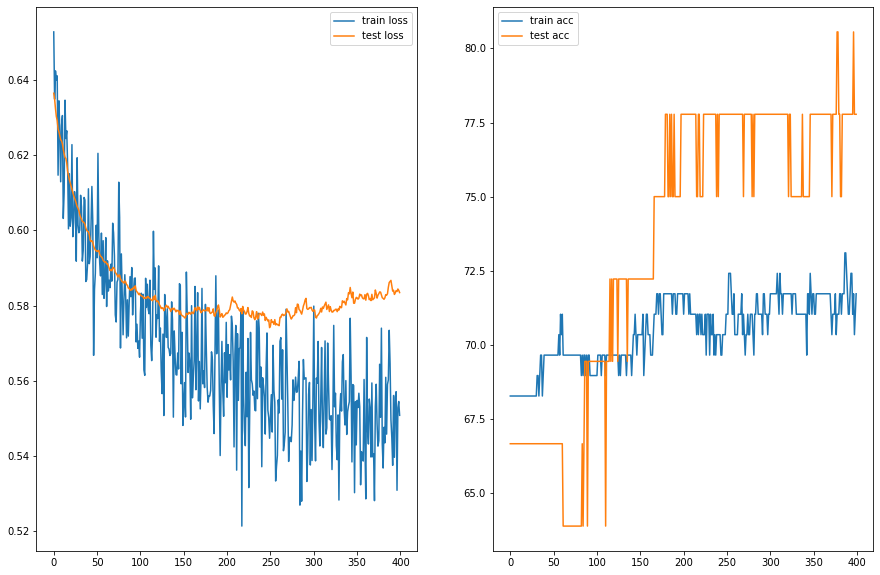

----------------------------------------
! WARNING !: Optimizer is not specified, or a declaration error occurs.
'SGD' as default, has been assigned.'
----------------------------------------
EPOCH : 1
------------------------------
TRAIN Details:
ACCURACY:  61.38  %
TRUE POSITIVE:  28 (  19.31 % )
TRUE NEGATIVE:  61 (  42.07 % )
FALSE POSITIVE:  38 (  26.21 % )
FALSE NEGATIVE:  18 (  12.41 % )
TRUE POSITIVE RATE(Sensitivity):  60.87  %
TRUE NEGATIVE RATE(Specificity):  61.62  %
POSITIVE PREDICTIVE VALUE(Precision):  42.42  %
NEGATIVE PREDICTIVE VALUE:  77.22  %
FALSE NEGATIVE RATE(Miss Rate):  39.13  %
FALSE POSITIVE RATE(Fall-out):  38.38  %
FALSE DISCOVERY RATE:  57.58  %
FALSE OMISSION RATE:  22.78  %
F1 SCORE:  50.00  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   7 (  19.44 % )
TRUE NEGATIVE:  17 (  47.22 % )
FALSE POSITIVE:   7 (  19.44 % )
FALSE NEGATIVE:   5 (  13.89 % )
TRUE POSITIVE RATE(Sensitivity):  58.33  %
TRUE NEGATIVE RATE(Specific

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


EPOCH : 3
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  95 (  65.52 % )
FALSE POSITIVE:   4 (  2.76 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  95.96  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  70.37  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  4.04  %
FALSE DISCOVERY RATE:  40.00  %
FALSE OMISSION RATE:  29.63  %
F1 SCORE:  21.43  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOV

------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPOCH : 13
------------------------------
TRAIN Details:
ACCURACY:  68.28  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  99 (  68.28 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  46 (  31.72 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  68.28  %
FALSE NEGATIVE RATE(Miss Ra

TRUE NEGATIVE RATE(Specificity):  98.99  %
POSITIVE PREDICTIVE VALUE(Precision):  75.00  %
NEGATIVE PREDICTIVE VALUE:  69.50  %
FALSE NEGATIVE RATE(Miss Rate):  93.48  %
FALSE POSITIVE RATE(Fall-out):  1.01  %
FALSE DISCOVERY RATE:  25.00  %
FALSE OMISSION RATE:  30.50  %
F1 SCORE:  12.00  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  0.00  %
----------------------------------------------------------------------
EPOCH : 22
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   3 (  2.07 % )
T

EPOCH : 30
------------------------------
TRAIN Details:
ACCURACY:  68.28  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  99 (  68.28 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  46 (  31.72 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  68.28  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  31.72  %
F1 SCORE:  0.00  %
------------------------------
TEST Details:
ACCURACY:  66.67  %
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY

EPOCH : 39
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   4 (  2.76 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   1 (  0.69 % )
FALSE NEGATIVE:  42 (  28.97 % )
TRUE POSITIVE RATE(Sensitivity):  8.70  %
TRUE NEGATIVE RATE(Specificity):  98.99  %
POSITIVE PREDICTIVE VALUE(Precision):  80.00  %
NEGATIVE PREDICTIVE VALUE:  70.00  %
FALSE NEGATIVE RATE(Miss Rate):  91.30  %
FALSE POSITIVE RATE(Fall-out):  1.01  %
FALSE DISCOVERY RATE:  20.00  %
FALSE OMISSION RATE:  30.00  %
F1 SCORE:  15.69  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVE

TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 49
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   4 (  2.76 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   1 (  0.69 % )
FALSE NEGATIVE:  42 (  28.97 % )
TRUE POSITIVE RATE(Sensitivity):  8.70  %
TRUE NEGATIVE RATE(Specificity):  98.99  %
POSITIVE PREDICTIVE VALUE(Precision):  80.00  %
NEGATIVE PREDICTIVE VALUE:  70.00  %
FALSE NEGATIVE RATE(Miss Rate):  91.30  %
FALSE POSITIVE RATE(Fall-out):  1.01  %
FALSE DISCOVERY RATE:  20.00  %
FALSE OMISSION RATE:  30.00  %
F1 SCORE:  15.69  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )

ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 59
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   4 (  2.76 % )
TRUE NEGATIVE:  98 (  67.59 % )
FALSE POSITIVE:   1 (  0.69 % )
FALSE NEGATIVE:  42 (  28.97 % )
TRUE POSITIVE RATE(Sensitivity):  8.70  %
TRUE NEGATIVE RATE(Specificity):  98.99  %
POSITIVE PREDICTIVE VALUE(Precision):  80.00  %
NEGATIVE PREDICTIVE VALUE:  70.00  %
FALSE NEGATIVE RATE(Miss Rate):  91.30  %
FALSE POSITIVE RATE(Fall-out

FALSE DISCOVERY RATE:  28.57  %
FALSE OMISSION RATE:  29.71  %
F1 SCORE:  18.87  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 68
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  96 (  66.21 % )
FALSE POSITIVE:   3 (  2.07 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  96.97  %
POSITIVE PREDICTIVE VALUE(

FALSE POSITIVE:   2 (  1.38 % )
FALSE NEGATIVE:  41 (  28.28 % )
TRUE POSITIVE RATE(Sensitivity):  10.87  %
TRUE NEGATIVE RATE(Specificity):  97.98  %
POSITIVE PREDICTIVE VALUE(Precision):  71.43  %
NEGATIVE PREDICTIVE VALUE:  70.29  %
FALSE NEGATIVE RATE(Miss Rate):  89.13  %
FALSE POSITIVE RATE(Fall-out):  2.02  %
FALSE DISCOVERY RATE:  28.57  %
FALSE OMISSION RATE:  29.71  %
F1 SCORE:  18.87  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------

EPOCH : 85
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  96 (  66.21 % )
FALSE POSITIVE:   3 (  2.07 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  96.97  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  3.03  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  21.82  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOV

FALSE POSITIVE RATE(Fall-out):  3.03  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  21.82  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 95
------------------------------
TRAIN Details:
ACCURACY:  70.34  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  96 (  66.21 % )
FALSE POSITIVE:   3 (  2.07 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificit

FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 105
------------------------------
TRAIN Details:
ACCURACY:  68.97  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  94 (  64.83 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  94.95  %
POSITIVE PREDICTIVE VALUE(Precision):  54.55  %
NEGATIVE PREDICTIVE VALUE:  70.15  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  5.05  %
FALSE DISCOVERY RATE:  45.45  %
FALSE OMISSION RATE:  29.85  %
F1 SCO

FALSE POSITIVE RATE(Fall-out):  5.05  %
FALSE DISCOVERY RATE:  45.45  %
FALSE OMISSION RATE:  29.85  %
F1 SCORE:  21.05  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 114
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  95 (  65.52 % )
FALSE POSITIVE:   4 (  2.76 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specific

FALSE POSITIVE RATE(Fall-out):  5.05  %
FALSE DISCOVERY RATE:  45.45  %
FALSE OMISSION RATE:  29.85  %
F1 SCORE:  21.05  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 123
------------------------------
TRAIN Details:
ACCURACY:  68.97  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  94 (  64.83 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specific

FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  94.95  %
POSITIVE PREDICTIVE VALUE(Precision):  54.55  %
NEGATIVE PREDICTIVE VALUE:  70.15  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  5.05  %
FALSE DISCOVERY RATE:  45.45  %
FALSE OMISSION RATE:  29.85  %
F1 SCORE:  21.05  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 133
------------------

FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 142
------------------------------
TRAIN Details:
ACCURACY:  68.97  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  94 (  64.83 % )
FALSE POSITIVE:   5 (  3.45 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  94.95  %
POSITIVE PREDICTIVE VALUE(Precision):  54.55  %
NEGATIVE PREDICTIVE VALUE:  70.15  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  5.05  %
FALSE DISCOVERY RATE:  45.45  %
FALSE OMISSION RATE:  29.85  %
F1 SCO

FALSE POSITIVE:   4 (  2.76 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  95.96  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  70.37  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  4.04  %
FALSE DISCOVERY RATE:  40.00  %
FALSE OMISSION RATE:  29.63  %
F1 SCORE:  21.43  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------

FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  21.82  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 161
------------------------------
TRAIN Details:
ACCURACY:  68.28  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   6 (  4.14 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  93.94  %
POSITIVE PREDICTIVE VALUE

FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 170
------------------------------
TRAIN Details:
ACCURACY:  69.66  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  95 (  65.52 % )
FALSE POSITIVE:   4 (  2.76 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  95.96  %
POSITIVE PREDICTIVE VALUE(Precision):  60.00  %
NEGATIVE PREDICTIVE VALUE:  70.37  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  4.04  %
FALSE DISCOVERY RATE:  40.00  %
FALSE OMISSION RATE:  29.63  %
F1 SCORE:  21.43  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE

FALSE NEGATIVE RATE(Miss Rate):  84.78  %
FALSE POSITIVE RATE(Fall-out):  9.09  %
FALSE DISCOVERY RATE:  56.25  %
FALSE OMISSION RATE:  30.23  %
F1 SCORE:  22.58  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 179
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivi

EPOCH : 188
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  92 (  63.45 % )
FALSE POSITIVE:   7 (  4.83 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  92.93  %
POSITIVE PREDICTIVE VALUE(Precision):  46.15  %
NEGATIVE PREDICTIVE VALUE:  69.70  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  7.07  %
FALSE DISCOVERY RATE:  53.85  %
FALSE OMISSION RATE:  30.30  %
F1 SCORE:  20.34  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCO

ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  15.22  %
TRUE NEGATIVE RATE(Specificity):  90.91  %
POSITIVE PREDICTIVE VALUE(Precision):  43.75  %
NEGATIVE PREDICTIVE VALUE:  69.77  %
FALSE NEGATIVE RATE(Miss Rate):  84.78  %
FALSE POSITIVE RATE(Fall-out):  9.09  %
FALSE DISCOVERY RATE:  56.25  %
FALSE OMISSION RATE:  30.23  %
F1 SCORE:  22.58  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCOR

EPOCH : 208
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  15.22  %
TRUE NEGATIVE RATE(Specificity):  90.91  %
POSITIVE PREDICTIVE VALUE(Precision):  43.75  %
NEGATIVE PREDICTIVE VALUE:  69.77  %
FALSE NEGATIVE RATE(Miss Rate):  84.78  %
FALSE POSITIVE RATE(Fall-out):  9.09  %
FALSE DISCOVERY RATE:  56.25  %
FALSE OMISSION RATE:  30.23  %
F1 SCORE:  22.58  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCO

F1 SCORE:  20.34  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 218
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  15.22  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  46.67  %
NEGATIVE PREDICTIVE VALUE:  70.00  %
FAL

FALSE POSITIVE RATE(Fall-out):  9.09  %
FALSE DISCOVERY RATE:  56.25  %
FALSE OMISSION RATE:  30.23  %
F1 SCORE:  22.58  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 227
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  15.22  %
TRUE NEGATIVE RATE(Specifici

EPOCH : 236
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  15.22  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  46.67  %
NEGATIVE PREDICTIVE VALUE:  70.00  %
FALSE NEGATIVE RATE(Miss Rate):  84.78  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  53.33  %
FALSE OMISSION RATE:  30.00  %
F1 SCORE:  22.95  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCO

TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  31.43  %
F1 SCORE:  15.38  %
----------------------------------------------------------------------
EPOCH : 246
------------------------------
TRAIN Details:
ACCURACY:  68.28  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  93 (  64.14 % )
FALSE POSITIVE:   6 (  4.14 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  93.94  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  69.92  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  6.06  %
FALSE DISCOVERY RATE:  50.00  %
FALSE

EPOCH : 254
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   6 (  4.14 % )
TRUE NEGATIVE:  91 (  62.76 % )
FALSE POSITIVE:   8 (  5.52 % )
FALSE NEGATIVE:  40 (  27.59 % )
TRUE POSITIVE RATE(Sensitivity):  13.04  %
TRUE NEGATIVE RATE(Specificity):  91.92  %
POSITIVE PREDICTIVE VALUE(Precision):  42.86  %
NEGATIVE PREDICTIVE VALUE:  69.47  %
FALSE NEGATIVE RATE(Miss Rate):  86.96  %
FALSE POSITIVE RATE(Fall-out):  8.08  %
FALSE DISCOVERY RATE:  57.14  %
FALSE OMISSION RATE:  30.53  %
F1 SCORE:  20.00  %
------------------------------
TEST Details:
ACCURACY:  69.44  %
TRUE POSITIVE:   1 (  2.78 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  11 (  30.56 % )
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  68.57  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCO

TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 265
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  15.22  %
TRUE NEGATIVE RATE(Specificity):  90.91  %
POSITIVE PREDICTIVE VALUE(Precision):  43.75  %
NEGATIVE PREDICTIVE VALUE:  69.77  %
FALSE NEGATIVE RATE(Miss Rate):  84.78  %
FALSE POSITIVE RATE(Fall-out):  9.09  %
FALSE DISCOVERY RATE:  56.25  %
FALS

NEGATIVE PREDICTIVE VALUE:  70.08  %
FALSE NEGATIVE RATE(Miss Rate):  82.61  %
FALSE POSITIVE RATE(Fall-out):  10.10  %
FALSE DISCOVERY RATE:  55.56  %
FALSE OMISSION RATE:  29.92  %
F1 SCORE:  25.00  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 274
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   8 (  5.52 % )
TRUE NEGATIVE:  89 (  61.38 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  38 (  

POSITIVE PREDICTIVE VALUE(Precision):  41.18  %
NEGATIVE PREDICTIVE VALUE:  69.53  %
FALSE NEGATIVE RATE(Miss Rate):  84.78  %
FALSE POSITIVE RATE(Fall-out):  10.10  %
FALSE DISCOVERY RATE:  58.82  %
FALSE OMISSION RATE:  30.47  %
F1 SCORE:  22.22  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 283
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE P

POSITIVE PREDICTIVE VALUE(Precision):  43.75  %
NEGATIVE PREDICTIVE VALUE:  69.77  %
FALSE NEGATIVE RATE(Miss Rate):  84.78  %
FALSE POSITIVE RATE(Fall-out):  9.09  %
FALSE DISCOVERY RATE:  56.25  %
FALSE OMISSION RATE:  30.23  %
F1 SCORE:  22.58  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 293
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE PO

FALSE DISCOVERY RATE:  56.25  %
FALSE OMISSION RATE:  30.23  %
F1 SCORE:  22.58  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 303
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  15.22  %
TRUE NEGATIVE RATE(Specificity):  90.91  %
POSITIVE PREDICTIVE VALU

TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 313
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   9 (  6.21 % )
TRUE NEGATIVE:  89 (  61.38 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  37 (  25.52 % )
TRUE POSITIVE RATE(Sensitivity):  19.57  %
TRUE NEGATIVE RATE(Specificity):  89.90  %
POSITIVE PREDICTIVE VALUE(Precision):  47.37  %
NEGATIVE PREDICTIVE VALUE:  70.63  %
FALSE NEGATIVE RATE(Miss Rate):  80.43  %
FALSE POSITIVE RATE(Fall-out):  10.10  %
FALSE DISCOVERY RATE:  52.63  %
FALSE OMISSION RATE:  29.37  %
F1 SCORE:  27.69  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 

FALSE DISCOVERY RATE:  55.00  %
FALSE OMISSION RATE:  29.60  %
F1 SCORE:  27.27  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 322
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  15.22  %
TRUE NEGATIVE RATE(Specificity):  90.91  %
POSITIVE PREDICTIVE VALU

POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 331
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   9 (  6.21 % )
TRUE NEGATIVE:  89 (  61.38 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  37 (  25.52 % )
TRUE POSITIVE RATE(Sensitivity):  19.57  %
TRUE NEGATIVE RATE(Specificity):  89.90  %
POSITIVE PREDICTIVE VALUE(Precision):  47.37  %
NEGATIVE PREDICTIVE VALUE:  70.63  %
FALSE NEGATIVE RATE(Miss Rate):  80.43  %
FALSE POSITIVE RATE(Fall-out):  10.10  %
FALSE DISCOVERY RATE:  52.63  %
FALSE OMISSION RATE:  29.37  %
F1 SCORE:  27.69  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE PO

FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 340
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   9 (  6.21 % )
TRUE NEGATIVE:  88 (  60.69 % )
FALSE POSITIVE:  11 (  7.59 % )
FALSE NEGATIVE:  37 (  25.52 % )
TRUE POSITIVE RATE(Sensitivity):  19.57  %
TRUE NEGATIVE RATE(Specificity):  88.89  %
POSITIVE PREDICTIVE VALUE(Precision):  45.00  %
NEGATIVE PREDICTIVE VALUE:  70.40  %
FALSE NEGATIVE RATE(Miss Rate):  80.43  %
FALSE POSITIVE RATE(Fall-out):  11.11  %
FALSE DISCOVERY RATE:  55.00  %
FALSE OMISSION RATE:  29.60  %
F1 SCORE:  27.27  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALU

EPOCH : 349
------------------------------
TRAIN Details:
ACCURACY:  67.59  %
TRUE POSITIVE:   9 (  6.21 % )
TRUE NEGATIVE:  89 (  61.38 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  37 (  25.52 % )
TRUE POSITIVE RATE(Sensitivity):  19.57  %
TRUE NEGATIVE RATE(Specificity):  89.90  %
POSITIVE PREDICTIVE VALUE(Precision):  47.37  %
NEGATIVE PREDICTIVE VALUE:  70.63  %
FALSE NEGATIVE RATE(Miss Rate):  80.43  %
FALSE POSITIVE RATE(Fall-out):  10.10  %
FALSE DISCOVERY RATE:  52.63  %
FALSE OMISSION RATE:  29.37  %
F1 SCORE:  27.69  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DIS

EPOCH : 359
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:  10 (  6.90 % )
TRUE NEGATIVE:  87 (  60.00 % )
FALSE POSITIVE:  12 (  8.28 % )
FALSE NEGATIVE:  36 (  24.83 % )
TRUE POSITIVE RATE(Sensitivity):  21.74  %
TRUE NEGATIVE RATE(Specificity):  87.88  %
POSITIVE PREDICTIVE VALUE(Precision):  45.45  %
NEGATIVE PREDICTIVE VALUE:  70.73  %
FALSE NEGATIVE RATE(Miss Rate):  78.26  %
FALSE POSITIVE RATE(Fall-out):  12.12  %
FALSE DISCOVERY RATE:  54.55  %
FALSE OMISSION RATE:  29.27  %
F1 SCORE:  29.41  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DIS

ACCURACY:  66.90  %
TRUE POSITIVE:   8 (  5.52 % )
TRUE NEGATIVE:  89 (  61.38 % )
FALSE POSITIVE:  10 (  6.90 % )
FALSE NEGATIVE:  38 (  26.21 % )
TRUE POSITIVE RATE(Sensitivity):  17.39  %
TRUE NEGATIVE RATE(Specificity):  89.90  %
POSITIVE PREDICTIVE VALUE(Precision):  44.44  %
NEGATIVE PREDICTIVE VALUE:  70.08  %
FALSE NEGATIVE RATE(Miss Rate):  82.61  %
FALSE POSITIVE RATE(Fall-out):  10.10  %
FALSE DISCOVERY RATE:  55.56  %
FALSE OMISSION RATE:  29.92  %
F1 SCORE:  25.00  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SC

EPOCH : 378
------------------------------
TRAIN Details:
ACCURACY:  68.28  %
TRUE POSITIVE:   9 (  6.21 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  37 (  25.52 % )
TRUE POSITIVE RATE(Sensitivity):  19.57  %
TRUE NEGATIVE RATE(Specificity):  90.91  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  70.87  %
FALSE NEGATIVE RATE(Miss Rate):  80.43  %
FALSE POSITIVE RATE(Fall-out):  9.09  %
FALSE DISCOVERY RATE:  50.00  %
FALSE OMISSION RATE:  29.13  %
F1 SCORE:  28.12  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISC

POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  29.41  %
F1 SCORE:  28.57  %
----------------------------------------------------------------------
EPOCH : 388
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:   7 (  4.83 % )
TRUE NEGATIVE:  90 (  62.07 % )
FALSE POSITIVE:   9 (  6.21 % )
FALSE NEGATIVE:  39 (  26.90 % )
TRUE POSITIVE RATE(Sensitivity):  15.22  %
TRUE NEGATIVE RATE(Specificity):  90.91  %
POSITIVE PREDICTIVE VALUE(Precision):  43.75  %
NEGATIVE PREDICTIVE VALUE:  69.77  %
FALSE NEGATIVE RATE(Miss Rate):  84.78  %
FALSE POSITIVE RATE(Fall-out):  9.09  %
FALSE DISCOVERY RATE:  56.25  %
FALSE OMISSION RATE:  30.23  %
F1 SCORE:  22.58  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POS

EPOCH : 397
------------------------------
TRAIN Details:
ACCURACY:  66.90  %
TRUE POSITIVE:  11 (  7.59 % )
TRUE NEGATIVE:  86 (  59.31 % )
FALSE POSITIVE:  13 (  8.97 % )
FALSE NEGATIVE:  35 (  24.14 % )
TRUE POSITIVE RATE(Sensitivity):  23.91  %
TRUE NEGATIVE RATE(Specificity):  86.87  %
POSITIVE PREDICTIVE VALUE(Precision):  45.83  %
NEGATIVE PREDICTIVE VALUE:  71.07  %
FALSE NEGATIVE RATE(Miss Rate):  76.09  %
FALSE POSITIVE RATE(Fall-out):  13.13  %
FALSE DISCOVERY RATE:  54.17  %
FALSE OMISSION RATE:  28.93  %
F1 SCORE:  31.43  %
------------------------------
TEST Details:
ACCURACY:  72.22  %
TRUE POSITIVE:   2 (  5.56 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  10 (  27.78 % )
TRUE POSITIVE RATE(Sensitivity):  16.67  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  70.59  %
FALSE NEGATIVE RATE(Miss Rate):  83.33  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DIS

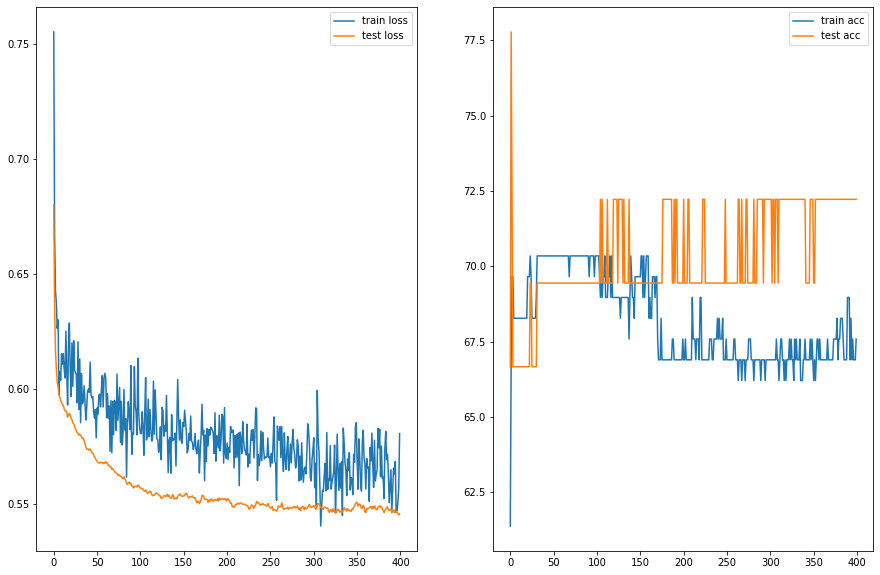

In [39]:
t0 = datetime.now()

acc_list = []
tpr_list = []
tnr_list = []
ppv_list = []
npv_list = []
fnr_list = []
fpr_list = []
fdr_list = []
_for_list = []
f1_list = []


for i in range(0,5):
    
    train_dataset = NewsDataset(x_data[index_storage[(i*2)]], y_data[index_storage[(i*2)]])
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)
    
    test_dataset = NewsDataset(x_data[index_storage[(i*2+1)]], y_data[index_storage[(i*2+1)]])
    test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = 0)
    
    model = NewsNet(input_size, hidden_size, output_size, activation_function, dropout_ratio).to(device)
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    optimizer = set_optimizer(option = optimizer, params = model.parameters(), lr = initial_learning_rate, weight_decay = weight_decay)
    loss_func = set_loss_fn(loss_function)

    for epoch in range(epochs):

        ### ------------------------------ Records for loss ------------------------------ 
        train_loss = []
        test_loss = []

        ### Train
        model.train()
        for i, (x, y) in enumerate(train_loader):
            #### Configured Device
            datas = x.to(device)
            labels = y.to(device)

            #### Set Gradients to zeros
            optimizer.zero_grad()

            #### Forward
            out = torch.reshape(model(datas.float()), (-1,))
            loss = loss_func(out, labels.float())

            #### Backward
            loss.backward()

            #### Optimize
            optimizer.step()

            #### Record
            train_loss.append(loss.item())

        ### ------------------------------ Records for Evaluation ------------------------------ 
        train_matrix = ConfusionMat()
        test_matrix = ConfusionMat()

        ### Evaluation
        model.eval()
        with torch.no_grad():
            #### Training
            for x, y in train_loader:
                ### Configured Device
                datas = x.to(device)
                labels = y.to(device)

                ### Predict
                out = model(datas.float())
                predict = nn.functional.relu(out)
                predict[predict > 0] = 1

                ### Judge
                predict_list = [element.item() for element in predict.flatten()]
                label_list = [element.item() for element in labels.flatten()]
                for i in range(len(predict_list)):
                    train_matrix.judge(predict_list[i], label_list[i])

            #### Testing
            for x, y in test_loader:
                ### Configured Device
                datas = x.to(device)
                labels = y.to(device)

                ### Predict
                out = model(datas.float())
                out_1 = torch.reshape(model(datas.float()), (-1,))
                loss = loss_func(out_1, labels.float())
                test_loss.append(loss)
                predict = nn.functional.relu(out)
                predict[predict > 0] = 1

                ### Judge
                predict_list = [element.item() for element in predict.flatten()]
                label_list = [element.item() for element in labels.flatten()]
                test_matrix.judge(predict_list[0], label_list[0])       

        ### Output
        train_losses.append(np.mean(train_loss))
        test_losses.append(np.mean(test_loss))

        print("EPOCH : {}".format(epoch+1))
        print("-"*30)
        print("TRAIN Details:")
        train_acc.append(train_matrix.acc())
        train_matrix.printMatrix()
        train_matrix.tpr()
        train_matrix.tnr()
        train_matrix.ppv()
        train_matrix.npv()
        train_matrix.fnr()
        train_matrix.fpr()
        train_matrix.fdr()
        train_matrix._for()
        train_matrix.f1()
        
        print("-"*30)
        print("TEST Details:")
        test_acc.append(test_matrix.acc())
        test_matrix.printMatrix()
        test_matrix.tpr()
        test_matrix.tnr()
        test_matrix.ppv()
        test_matrix.npv()
        test_matrix.fnr()
        test_matrix.fpr()
        test_matrix.fdr()
        test_matrix._for()
        test_matrix.f1()
        print("-"*70)
        
        if epoch == epochs-1:
            acc_list.append(test_matrix.acc())
            tpr_list.append(test_matrix.tpr())
            tnr_list.append(test_matrix.tnr())
            ppv_list.append(test_matrix.ppv())
            npv_list.append(test_matrix.npv())
            fnr_list.append(test_matrix.fnr())
            fpr_list.append(test_matrix.fpr())
            fdr_list.append(test_matrix.fdr())
            _for_list.append(test_matrix._for())
            f1_list.append(test_matrix.f1())
            
        
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_losses, label='test loss')
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='best')
    ax2.plot(train_acc, label='train acc')
    ax2.plot(test_acc, label='test acc')
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc='best')
    plt.show()

t1 = datetime.now()




In [40]:
print("*"*60)

print("ACCURACY: {: .2f}  %".format(sum(acc_list)/5))
print("TRUE POSITIVE RATE(Sensitivity): {: .2f}  %".format(sum(tpr_list)/5))
print("TRUE NEGATIVE RATE(Specificity): {: .2f}  %".format(sum(tnr_list)/5))
print("POSITIVE PREDICTIVE VALUE(Precision): {: .2f}  %".format(sum(ppv_list)/5))
print("NEGATIVE PREDICTIVE VALUE: {: .2f}  %".format(sum(npv_list)/5))
print("FALSE NEGATIVE RATE(Miss Rate): {: .2f}  %".format(sum(fnr_list)/5))
print("FALSE POSITIVE RATE(Fall-out): {: .2f}  %".format(sum(fpr_list)/5))
print("FALSE DISCOVERY RATE: {: .2f}  %".format(sum(fdr_list)/5))
print("FALSE OMISSION RATE: {: .2f}  %".format(sum(_for_list)/5))
print("F1 SCORE: {: .2f}  %".format(sum(f1_list)/5))
print("Training Time: " + str(t1 - t0))

print("*"*60)

************************************************************
ACCURACY:  70.71  %
TRUE POSITIVE RATE(Sensitivity):  30.76  %
TRUE NEGATIVE RATE(Specificity):  89.53  %
POSITIVE PREDICTIVE VALUE(Precision):  64.50  %
NEGATIVE PREDICTIVE VALUE:  73.41  %
FALSE NEGATIVE RATE(Miss Rate):  69.24  %
FALSE POSITIVE RATE(Fall-out):  10.47  %
FALSE DISCOVERY RATE:  35.50  %
FALSE OMISSION RATE:  26.59  %
F1 SCORE:  39.42  %
Training Time: 0:02:18.060831
************************************************************


In [34]:
from sklearn.ensemble import RandomForestClassifier
import random

In [88]:

acc_list = []
tpr_list = []
tnr_list = []
ppv_list = []
npv_list = []
fnr_list = []
fpr_list = []
fdr_list = []
_for_list = []
f1_list = []

t0 = datetime.now()

for i in range(0,5):
    forest = RandomForestClassifier(n_estimators = 100, random_state=4388)
    test_matrix = ConfusionMat()
    
    forest_fit = forest.fit(x_data[index_storage[i*2]], y_data[index_storage[i*2]])
    test_y_predicted = forest.predict(x_data[index_storage[i*2+1]])
    
    for j in range(0,len(test_y_predicted)):
        test_matrix.judge(test_y_predicted[j], y_data[index_storage[i*2+1]][j])
    
    acc_list.append(test_matrix.acc())
    tpr_list.append(test_matrix.tpr())
    tnr_list.append(test_matrix.tnr())
    ppv_list.append(test_matrix.ppv())
    npv_list.append(test_matrix.npv())
    fnr_list.append(test_matrix.fnr())
    fpr_list.append(test_matrix.fpr())
    fdr_list.append(test_matrix.fdr())
    _for_list.append(test_matrix._for())
    f1_list.append(test_matrix.f1())
    
    
t1 = datetime.now()
       

ACCURACY:  62.16  %
TRUE POSITIVE RATE(Sensitivity):  25.00  %
TRUE NEGATIVE RATE(Specificity):  80.00  %
POSITIVE PREDICTIVE VALUE(Precision):  37.50  %
NEGATIVE PREDICTIVE VALUE:  68.97  %
FALSE NEGATIVE RATE(Miss Rate):  75.00  %
FALSE POSITIVE RATE(Fall-out):  20.00  %
FALSE DISCOVERY RATE:  62.50  %
FALSE OMISSION RATE:  31.03  %
F1 SCORE:  30.00  %
ACCURACY:  69.44  %
TRUE POSITIVE RATE(Sensitivity):  36.36  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  50.00  %
NEGATIVE PREDICTIVE VALUE:  75.00  %
FALSE NEGATIVE RATE(Miss Rate):  63.64  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  50.00  %
FALSE OMISSION RATE:  25.00  %
F1 SCORE:  42.11  %
ACCURACY:  52.78  %
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  64.00  %
POSITIVE PREDICTIVE VALUE(Precision):  25.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  36.00  %
FALSE DISCOV

In [89]:
print("*"*60)

print("ACCURACY: {: .2f}  %".format(sum(acc_list)/5))
print("TRUE POSITIVE RATE(Sensitivity): {: .2f}  %".format(sum(tpr_list)/5))
print("TRUE NEGATIVE RATE(Specificity): {: .2f}  %".format(sum(tnr_list)/5))
print("POSITIVE PREDICTIVE VALUE(Precision): {: .2f}  %".format(sum(ppv_list)/5))
print("NEGATIVE PREDICTIVE VALUE: {: .2f}  %".format(sum(npv_list)/5))
print("FALSE NEGATIVE RATE(Miss Rate): {: .2f}  %".format(sum(fnr_list)/5))
print("FALSE POSITIVE RATE(Fall-out): {: .2f}  %".format(sum(fpr_list)/5))
print("FALSE DISCOVERY RATE: {: .2f}  %".format(sum(fdr_list)/5))
print("FALSE OMISSION RATE: {: .2f}  %".format(sum(_for_list)/5))
print("F1 SCORE: {: .2f}  %".format(sum(f1_list)/5))
print("Training Time: " + str(t1 - t0))

print("*"*60)

************************************************************
ACCURACY:  62.99  %
TRUE POSITIVE RATE(Sensitivity):  27.73  %
TRUE NEGATIVE RATE(Specificity):  79.77  %
POSITIVE PREDICTIVE VALUE(Precision):  40.60  %
NEGATIVE PREDICTIVE VALUE:  69.94  %
FALSE NEGATIVE RATE(Miss Rate):  72.27  %
FALSE POSITIVE RATE(Fall-out):  20.23  %
FALSE DISCOVERY RATE:  59.40  %
FALSE OMISSION RATE:  30.06  %
F1 SCORE:  32.50  %
Training Time: 0:00:00.581517
************************************************************


In [90]:
from sklearn import linear_model

In [86]:

acc_list = []
tpr_list = []
tnr_list = []
ppv_list = []
npv_list = []
fnr_list = []
fpr_list = []
fdr_list = []
_for_list = []
f1_list = []

t0 = datetime.now()

for i in range(0,5):
    logReg = linear_model.LogisticRegression(random_state=4388)
    test_matrix = ConfusionMat()
    
    logReg_fit = logReg.fit(x_data[index_storage[i*2]], y_data[index_storage[i*2]])
    test_y_predicted = forest.predict(x_data[index_storage[i*2+1]])
    
    for j in range(0,len(test_y_predicted)):
        test_matrix.judge(test_y_predicted[j], y_data[index_storage[i*2+1]][j])
    
    acc_list.append(test_matrix.acc())
    tpr_list.append(test_matrix.tpr())
    tnr_list.append(test_matrix.tnr())
    ppv_list.append(test_matrix.ppv())
    npv_list.append(test_matrix.npv())
    fnr_list.append(test_matrix.fnr())
    fpr_list.append(test_matrix.fpr())
    fdr_list.append(test_matrix.fdr())
    _for_list.append(test_matrix._for())
    f1_list.append(test_matrix.f1())
    
t1 = datetime.now()

ACCURACY:  100.00  %
TRUE POSITIVE RATE(Sensitivity):  100.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  100.00  %
FALSE NEGATIVE RATE(Miss Rate):  0.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  0.00  %
F1 SCORE:  100.00  %
ACCURACY:  100.00  %
TRUE POSITIVE RATE(Sensitivity):  100.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  100.00  %
FALSE NEGATIVE RATE(Miss Rate):  0.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE:  0.00  %
FALSE OMISSION RATE:  0.00  %
F1 SCORE:  100.00  %
ACCURACY:  100.00  %
TRUE POSITIVE RATE(Sensitivity):  100.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision):  100.00  %
NEGATIVE PREDICTIVE VALUE:  100.00  %
FALSE NEGATIVE RATE(Miss Rate):  0.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE

In [87]:
print("*"*60)

print("ACCURACY: {: .2f}  %".format(sum(acc_list)/5))
print("TRUE POSITIVE RATE(Sensitivity): {: .2f}  %".format(sum(tpr_list)/5))
print("TRUE NEGATIVE RATE(Specificity): {: .2f}  %".format(sum(tnr_list)/5))
print("POSITIVE PREDICTIVE VALUE(Precision): {: .2f}  %".format(sum(ppv_list)/5))
print("NEGATIVE PREDICTIVE VALUE: {: .2f}  %".format(sum(npv_list)/5))
print("FALSE NEGATIVE RATE(Miss Rate): {: .2f}  %".format(sum(fnr_list)/5))
print("FALSE POSITIVE RATE(Fall-out): {: .2f}  %".format(sum(fpr_list)/5))
print("FALSE DISCOVERY RATE: {: .2f}  %".format(sum(fdr_list)/5))
print("FALSE OMISSION RATE: {: .2f}  %".format(sum(_for_list)/5))
print("F1 SCORE: {: .2f}  %".format(sum(f1_list)/5))
print("Training Time: " + str(t1 - t0))

print("*"*60)

************************************************************
ACCURACY:  92.22  %
TRUE POSITIVE RATE(Sensitivity):  83.33  %
TRUE NEGATIVE RATE(Specificity):  96.67  %
POSITIVE PREDICTIVE VALUE(Precision):  86.67  %
NEGATIVE PREDICTIVE VALUE:  93.33  %
FALSE NEGATIVE RATE(Miss Rate):  16.67  %
FALSE POSITIVE RATE(Fall-out):  3.33  %
FALSE DISCOVERY RATE:  13.33  %
FALSE OMISSION RATE:  6.67  %
F1 SCORE:  84.44  %
Training Time: 0:00:00.088388
************************************************************


In [40]:
from sklearn.svm import SVC

In [91]:

acc_list = []
tpr_list = []
tnr_list = []
ppv_list = []
npv_list = []
fnr_list = []
fpr_list = []
fdr_list = []
_for_list = []
f1_list = []

t0 = datetime.now()

for i in range(0,5):
    svc = SVC(kernel = 'linear', probability = True, random_state=4388)
    test_matrix = ConfusionMat()
    
    svc_fit = svc.fit(x_data[index_storage[i*2]], y_data[index_storage[i*2]])
    test_y_predicted = svc_fit.predict(x_data[index_storage[i*2+1]])
    
    for j in range(0,len(test_y_predicted)):
        test_matrix.judge(test_y_predicted[j], y_data[index_storage[i*2+1]][j])
    
    acc_list.append(test_matrix.acc())
    tpr_list.append(test_matrix.tpr())
    tnr_list.append(test_matrix.tnr())
    ppv_list.append(test_matrix.ppv())
    npv_list.append(test_matrix.npv())
    fnr_list.append(test_matrix.fnr())
    fpr_list.append(test_matrix.fpr())
    fdr_list.append(test_matrix.fdr())
    _for_list.append(test_matrix._for())
    f1_list.append(test_matrix.f1())
    
t1 = datetime.now()

ACCURACY:  72.97  %
TRUE POSITIVE RATE(Sensitivity):  33.33  %
TRUE NEGATIVE RATE(Specificity):  92.00  %
POSITIVE PREDICTIVE VALUE(Precision):  66.67  %
NEGATIVE PREDICTIVE VALUE:  74.19  %
FALSE NEGATIVE RATE(Miss Rate):  66.67  %
FALSE POSITIVE RATE(Fall-out):  8.00  %
FALSE DISCOVERY RATE:  33.33  %
FALSE OMISSION RATE:  25.81  %
F1 SCORE:  44.44  %
ACCURACY:  66.67  %
TRUE POSITIVE RATE(Sensitivity):  27.27  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  42.86  %
NEGATIVE PREDICTIVE VALUE:  72.41  %
FALSE NEGATIVE RATE(Miss Rate):  72.73  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVERY RATE:  57.14  %
FALSE OMISSION RATE:  27.59  %
F1 SCORE:  33.33  %
ACCURACY:  63.89  %
TRUE POSITIVE RATE(Sensitivity):  18.18  %
TRUE NEGATIVE RATE(Specificity):  84.00  %
POSITIVE PREDICTIVE VALUE(Precision):  33.33  %
NEGATIVE PREDICTIVE VALUE:  70.00  %
FALSE NEGATIVE RATE(Miss Rate):  81.82  %
FALSE POSITIVE RATE(Fall-out):  16.00  %
FALSE DISCOVE

In [92]:
print("*"*60)

print("ACCURACY: {: .2f}  %".format(sum(acc_list)/5))
print("TRUE POSITIVE RATE(Sensitivity): {: .2f}  %".format(sum(tpr_list)/5))
print("TRUE NEGATIVE RATE(Specificity): {: .2f}  %".format(sum(tnr_list)/5))
print("POSITIVE PREDICTIVE VALUE(Precision): {: .2f}  %".format(sum(ppv_list)/5))
print("NEGATIVE PREDICTIVE VALUE: {: .2f}  %".format(sum(npv_list)/5))
print("FALSE NEGATIVE RATE(Miss Rate): {: .2f}  %".format(sum(fnr_list)/5))
print("FALSE POSITIVE RATE(Fall-out): {: .2f}  %".format(sum(fpr_list)/5))
print("FALSE DISCOVERY RATE: {: .2f}  %".format(sum(fdr_list)/5))
print("FALSE OMISSION RATE: {: .2f}  %".format(sum(_for_list)/5))
print("F1 SCORE: {: .2f}  %".format(sum(f1_list)/5))
print("Training Time: " + str(t1 - t0))

print("*"*60)

************************************************************
ACCURACY:  67.37  %
TRUE POSITIVE RATE(Sensitivity):  32.42  %
TRUE NEGATIVE RATE(Specificity):  83.67  %
POSITIVE PREDICTIVE VALUE(Precision):  48.77  %
NEGATIVE PREDICTIVE VALUE:  72.54  %
FALSE NEGATIVE RATE(Miss Rate):  67.58  %
FALSE POSITIVE RATE(Fall-out):  16.33  %
FALSE DISCOVERY RATE:  51.23  %
FALSE OMISSION RATE:  27.46  %
F1 SCORE:  38.48  %
Training Time: 0:00:00.017952
************************************************************


In [43]:
from xgboost import XGBClassifier
import xgboost as xgb

In [93]:

acc_list = []
tpr_list = []
tnr_list = []
ppv_list = []
npv_list = []
fnr_list = []
fpr_list = []
fdr_list = []
_for_list = []
f1_list = []

t0 = datetime.now()

for i in range(0,5):
    xgm = XGBClassifier(booster = 'gbtree',
    learning_rate = 0.25,
    n_estimatores = 1800,
    objective = 'binary:logistic',
    max_depth = 20,
    subsample = 0.75,
    colsample_bytree = 0.6,
    min_child_weight = 0.1,
    max_delta_step = 1,
    eta = 0.7,
    seed = 101,
    gamma = 5,
    alpha = 0,
    random_state = 4388)
    test_matrix = ConfusionMat()
    
    xgm_fit = xgm.fit(x_data[index_storage[i*2]], y_data[index_storage[i*2]])
    test_y_predicted = xgm_fit.predict(x_data[index_storage[i*2+1]])
    
    for j in range(0,len(test_y_predicted)):
        test_matrix.judge(test_y_predicted[j], y_data[index_storage[i*2+1]][j])
    
    acc_list.append(test_matrix.acc())
    tpr_list.append(test_matrix.tpr())
    tnr_list.append(test_matrix.tnr())
    ppv_list.append(test_matrix.ppv())
    npv_list.append(test_matrix.npv())
    fnr_list.append(test_matrix.fnr())
    fpr_list.append(test_matrix.fpr())
    fdr_list.append(test_matrix.fdr())
    _for_list.append(test_matrix._for())
    f1_list.append(test_matrix.f1())
    
t1 = datetime.now()

[20:26:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimatores } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


ACCURACY:  64.86  %
TRUE POSITIVE RATE(Sensitivity):  8.33  %
TRUE NEGATIVE RATE(Specificity):  92.00  %
POSITIVE PREDICTIVE VALUE(Precision):  33.33  %
NEGATIVE PREDICTIVE VALUE:  67.65  %
FALSE NEGATIVE RATE(Miss Rate):  91.67  %
FALSE POSITIVE RATE(Fall-out):  8.00  %
FALSE DISCOVERY RATE:  66.67  %
FALSE OMISSION RATE:  32.35  %
F1 SCORE:  13.33  %
[20:26:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimatores } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down

In [94]:
print("*"*60)

print("ACCURACY: {: .2f}  %".format(sum(acc_list)/5))
print("TRUE POSITIVE RATE(Sensitivity): {: .2f}  %".format(sum(tpr_list)/5))
print("TRUE NEGATIVE RATE(Specificity): {: .2f}  %".format(sum(tnr_list)/5))
print("POSITIVE PREDICTIVE VALUE(Precision): {: .2f}  %".format(sum(ppv_list)/5))
print("NEGATIVE PREDICTIVE VALUE: {: .2f}  %".format(sum(npv_list)/5))
print("FALSE NEGATIVE RATE(Miss Rate): {: .2f}  %".format(sum(fnr_list)/5))
print("FALSE POSITIVE RATE(Fall-out): {: .2f}  %".format(sum(fpr_list)/5))
print("FALSE DISCOVERY RATE: {: .2f}  %".format(sum(fdr_list)/5))
print("FALSE OMISSION RATE: {: .2f}  %".format(sum(_for_list)/5))
print("F1 SCORE: {: .2f}  %".format(sum(f1_list)/5))
print("Training Time: " + str(t1 - t0))

print("*"*60)

************************************************************
ACCURACY:  66.31  %
TRUE POSITIVE RATE(Sensitivity):  19.24  %
TRUE NEGATIVE RATE(Specificity):  88.70  %
POSITIVE PREDICTIVE VALUE(Precision):  44.22  %
NEGATIVE PREDICTIVE VALUE:  70.07  %
FALSE NEGATIVE RATE(Miss Rate):  80.76  %
FALSE POSITIVE RATE(Fall-out):  11.30  %
FALSE DISCOVERY RATE:  55.78  %
FALSE OMISSION RATE:  29.93  %
F1 SCORE:  25.29  %
Training Time: 0:00:00.277259
************************************************************


In [46]:
import eli5
from eli5.sklearn import PermutationImportance

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [47]:
acc_list

[64.86486486486487,
 66.66666666666666,
 63.888888888888886,
 69.44444444444444,
 66.66666666666666]

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

In [23]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=4388)

In [25]:
sss_i = sss.split(x_data, y_data)

In [28]:
X_train, X_test, Y_train, Y_test = 0,0,0,0
for train_i, test_i in sss_i:
    X_train, X_test = x_data[train_i], x_data[test_i]
    Y_train, Y_test = y_data[train_i], y_data[test_i]

In [29]:
X_train, X_test, Y_train, Y_test

(array([[ 3.09104245,  4.8598124 , -1.        , -1.        , -1.        ,
         -1.        ,  1.        ],
        [ 3.21887583,  4.78749174, -1.        , -1.        , -1.        ,
         -1.        ,  1.        ],
        [ 2.94443898,  5.01063529, -1.        , -1.        , -1.        ,
         -1.        ,  3.        ],
        [ 2.89037176,  5.433722  , -1.        , -1.        , -1.        ,
         -1.        ,  2.        ],
        [ 3.4657359 ,  5.13579844, -1.        , -1.        , -1.        ,
         -1.        ,  1.        ],
        [ 2.94443898,  5.45958551,  1.        ,  1.        , -1.        ,
         -1.        ,  1.        ],
        [ 3.29583687,  5.01063529, -1.        , -1.        , -1.        ,
         -1.        ,  3.        ],
        [ 2.94443898,  4.92725369,  1.        , -1.        , -1.        ,
         -1.        ,  1.        ],
        [ 3.40119738,  4.67282883, -1.        , -1.        ,  1.        ,
          1.        ,  3.        ],
        [ 

In [176]:
class slfn_model():
    
    def __init__(self, batch_size = 2, input_size = 7, hidden_size = 50, output_size = 1, 
                 dropout_ratio = 0.5, activation_function = "LReLU", epochs = 400, 
                 loss_function = "BCE", optimizer = "ADAM", initial_learning_rate = 10e-4,
                 weight_decay = 10e-4, random_seed = 4388):
    
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_ratio = dropout_ratio
        self.activation_function = activation_function
        self.epochs = epochs
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.initial_learning_rate = initial_learning_rate
        self.weight_decay = weight_decay
        self.random_seed = random_seed

        self.model = NewsNet(self.input_size, self.hidden_size, self.output_size, self.activation_function, self.dropout_ratio).to(device)

    
    def fit(self, train_x, train_y):
        
        self.train_dataset = NewsDataset(train_x, train_y)
        self.train_loader = DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True, num_workers = 0)
    
        train_losses = []
        test_losses = []
        train_acc = []
        test_acc = []
        optimizer = set_optimizer(self.optimizer, params = self.model.parameters(), lr = self.initial_learning_rate, weight_decay = self.weight_decay)
        loss_func = set_loss_fn(self.loss_function)

        for epoch in range(epochs):

            ### ------------------------------ Records for loss ------------------------------ 
            train_loss = []
            test_loss = []

            ### Train
            self.model.train()
            for i, (x, y) in enumerate(self.train_loader):
                #### Configured Device
                datas = x.to(device)
                labels = y.to(device)

                #### Set Gradients to zeros
                optimizer.zero_grad()

                #### Forward
                out = torch.reshape(self.model(datas.float()), (-1,))
                loss = loss_func(out, labels.float())

                #### Backward
                loss.backward()

                #### Optimize
                optimizer.step()

                #### Record
                train_loss.append(loss.item())

            ### ------------------------------ Records for Evaluation ------------------------------ 
            train_matrix = ConfusionMat()
            test_matrix = ConfusionMat()

            ### Evaluation
            self.model.eval()
            with torch.no_grad():
                #### Training
                for x, y in self.train_loader:
                    ### Configured Device
                    datas = x.to(device)
                    labels = y.to(device)

                    ### Predict
                    out = self.model(datas.float())
                    predict = nn.functional.relu(out)
                    predict[predict > 0] = 1

                    ### Judge
                    predict_list = [element.item() for element in predict.flatten()]
                    label_list = [element.item() for element in labels.flatten()]
                    for i in range(len(predict_list)):
                        train_matrix.judge(predict_list[i], label_list[i])

    #### Testing
    def predict(self, val_x, val_y):
        
        self.test_dataset = NewsDataset(val_x, val_y)
        self.test_loader = DataLoader(self.test_dataset, batch_size = 1, shuffle = True, num_workers = 0)
        loss_func = set_loss_fn(self.loss_function)
        
        predict_list = []
        
        for x, y in self.test_loader:
            ### Configured Device
            datas = x.to(device)
            labels = y.to(device)

            ### Predict
            out = self.model(datas.float())
            out_1 = torch.reshape(self.model(datas.float()), (-1,))
            loss = loss_func(out_1, labels.float())
            # predict = nn.functional.relu(out)
            predict = out
            # predict[predict > 0] = 1
            
            predict_list.append([element.item() for element in predict.flatten()][0])

        return predict_list

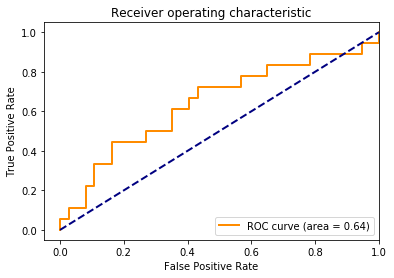

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


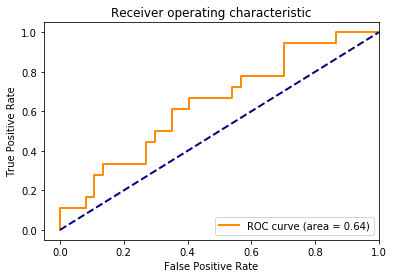

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


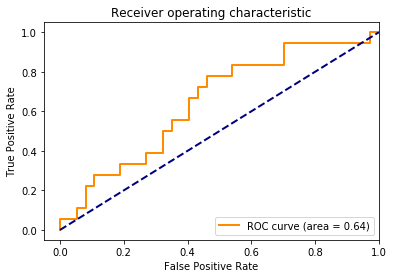

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


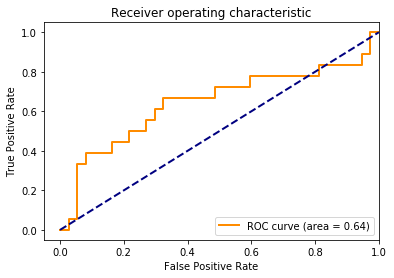

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


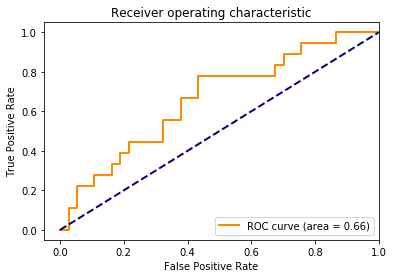

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


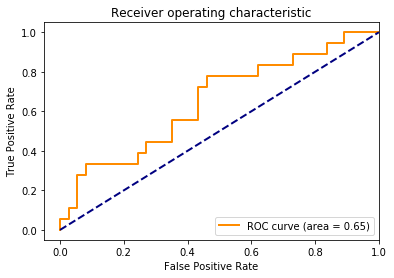

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


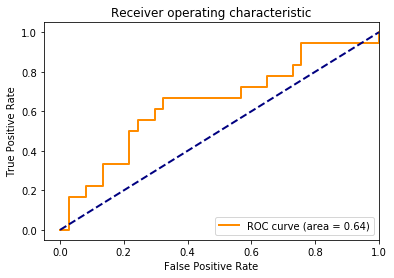

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


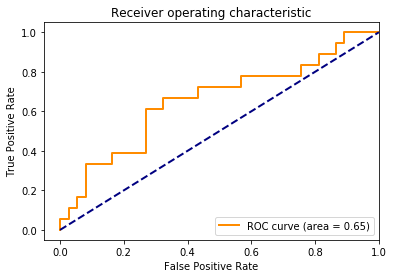

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


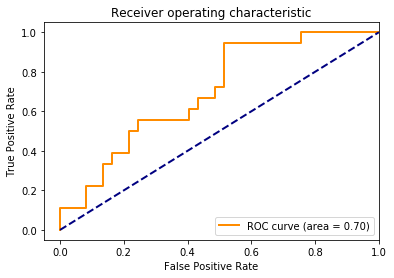

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


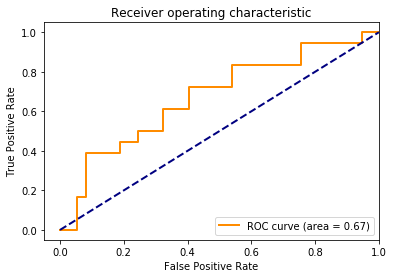

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


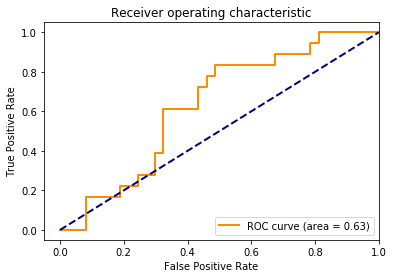

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


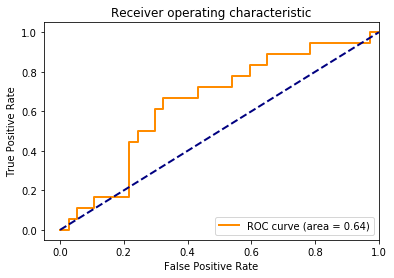

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


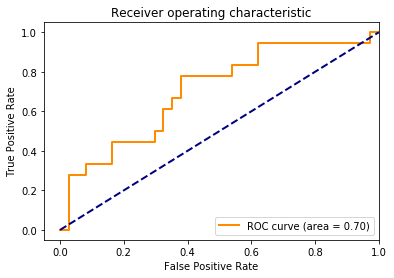

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


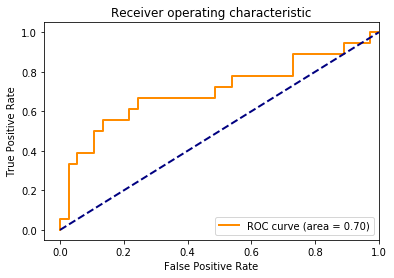

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


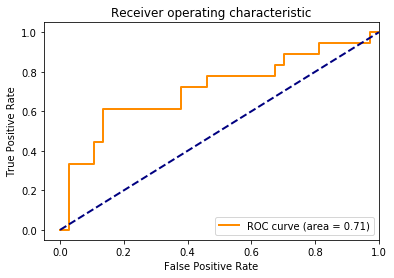

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


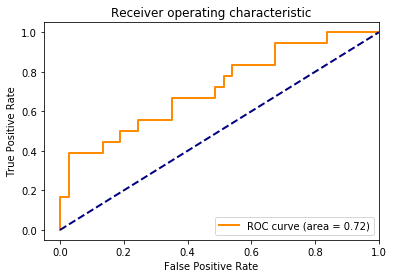

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


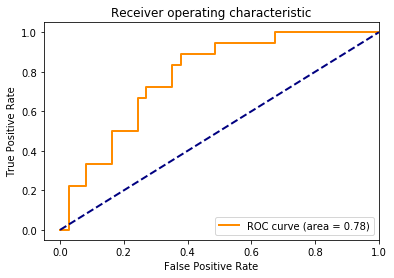

In [180]:
target = 0.75
while(True):
    class slfn_model():
    
        def __init__(self, batch_size = 2, input_size = 7, hidden_size = 50, output_size = 1, 
                     dropout_ratio = 0.5, activation_function = "LReLU", epochs = 400, 
                     loss_function = "BCE", optimizer = "ADAM", initial_learning_rate = 10e-4,
                     weight_decay = 10e-4, random_seed = 4388):

            self.batch_size = batch_size
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size
            self.dropout_ratio = dropout_ratio
            self.activation_function = activation_function
            self.epochs = epochs
            self.loss_function = loss_function
            self.optimizer = optimizer
            self.initial_learning_rate = initial_learning_rate
            self.weight_decay = weight_decay
            self.random_seed = random_seed

            self.model = NewsNet(self.input_size, self.hidden_size, self.output_size, self.activation_function, self.dropout_ratio).to(device)


        def fit(self, train_x, train_y):

            self.train_dataset = NewsDataset(train_x, train_y)
            self.train_loader = DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True, num_workers = 0)

            train_losses = []
            test_losses = []
            train_acc = []
            test_acc = []
            optimizer = set_optimizer(self.optimizer, params = self.model.parameters(), lr = self.initial_learning_rate, weight_decay = self.weight_decay)
            loss_func = set_loss_fn(self.loss_function)

            for epoch in range(epochs):

                ### ------------------------------ Records for loss ------------------------------ 
                train_loss = []
                test_loss = []

                ### Train
                self.model.train()
                for i, (x, y) in enumerate(self.train_loader):
                    #### Configured Device
                    datas = x.to(device)
                    labels = y.to(device)

                    #### Set Gradients to zeros
                    optimizer.zero_grad()

                    #### Forward
                    out = torch.reshape(self.model(datas.float()), (-1,))
                    loss = loss_func(out, labels.float())

                    #### Backward
                    loss.backward()

                    #### Optimize
                    optimizer.step()

                    #### Record
                    train_loss.append(loss.item())

                ### ------------------------------ Records for Evaluation ------------------------------ 
                train_matrix = ConfusionMat()
                test_matrix = ConfusionMat()

                ### Evaluation
                self.model.eval()
                with torch.no_grad():
                    #### Training
                    for x, y in self.train_loader:
                        ### Configured Device
                        datas = x.to(device)
                        labels = y.to(device)

                        ### Predict
                        out = self.model(datas.float())
                        predict = nn.functional.relu(out)
                        predict[predict > 0] = 1

                        ### Judge
                        predict_list = [element.item() for element in predict.flatten()]
                        label_list = [element.item() for element in labels.flatten()]
                        for i in range(len(predict_list)):
                            train_matrix.judge(predict_list[i], label_list[i])

        #### Testing
        def predict(self, val_x, val_y):

            self.test_dataset = NewsDataset(val_x, val_y)
            self.test_loader = DataLoader(self.test_dataset, batch_size = 1, shuffle = True, num_workers = 0)
            loss_func = set_loss_fn(self.loss_function)

            predict_list = []

            for x, y in self.test_loader:
                ### Configured Device
                datas = x.to(device)
                labels = y.to(device)

                ### Predict
                out = self.model(datas.float())
                out_1 = torch.reshape(self.model(datas.float()), (-1,))
                loss = loss_func(out_1, labels.float())
                # predict = nn.functional.relu(out)
                predict = out
                # predict[predict > 0] = 1

                predict_list.append([element.item() for element in predict.flatten()][0])

            return predict_list
    slfn_model = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 30, dropout_ratio = 0.3)
    slfn_model.fit(X_train, Y_train)
    y_pred = slfn_model.predict(X_test,Y_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(Y_test[:], y_pred[:])
    roc_auc = auc(fpr, tpr)
    if roc_auc >= 0.63:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.05, 1.0])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
    if roc_auc >= 0.75:
        break
    
    

In [171]:
slfn_model = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 30, dropout_ratio = 0.35)

In [172]:
slfn_model.fit(X_train, Y_train)

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [173]:
y_pred = slfn_model.predict(X_test,Y_test)

In [174]:

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(Y_test[:], y_pred[:])
roc_auc = auc(fpr, tpr)


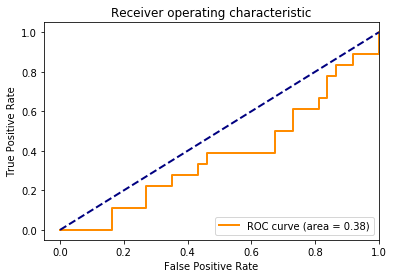

In [175]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [42]:
fpr, tpr, roc_auc

(array([0.        , 0.02702703, 0.02702703, 0.08108108, 0.08108108,
        0.10810811, 0.10810811, 0.16216216, 0.16216216, 0.21621622,
        0.21621622, 0.40540541, 0.40540541, 0.45945946, 0.45945946,
        0.51351351, 0.51351351, 0.62162162, 0.62162162, 0.7027027 ,
        0.7027027 , 0.72972973, 0.72972973, 0.91891892, 0.91891892,
        0.94594595, 0.94594595, 0.97297297, 0.97297297, 1.        ]),
 array([0.        , 0.        , 0.05555556, 0.05555556, 0.16666667,
        0.16666667, 0.22222222, 0.22222222, 0.27777778, 0.27777778,
        0.33333333, 0.33333333, 0.38888889, 0.38888889, 0.44444444,
        0.44444444, 0.5       , 0.5       , 0.55555556, 0.55555556,
        0.77777778, 0.77777778, 0.83333333, 0.83333333, 0.88888889,
        0.88888889, 0.94444444, 0.94444444, 1.        , 1.        ]),
 0.4969969969969969)

In [46]:
roc_curve(Y_test[:], y_pred[:])

(array([0.        , 0.02702703, 0.02702703, 0.08108108, 0.08108108,
        0.10810811, 0.10810811, 0.16216216, 0.16216216, 0.21621622,
        0.21621622, 0.40540541, 0.40540541, 0.45945946, 0.45945946,
        0.51351351, 0.51351351, 0.62162162, 0.62162162, 0.7027027 ,
        0.7027027 , 0.72972973, 0.72972973, 0.91891892, 0.91891892,
        0.94594595, 0.94594595, 0.97297297, 0.97297297, 1.        ]),
 array([0.        , 0.        , 0.05555556, 0.05555556, 0.16666667,
        0.16666667, 0.22222222, 0.22222222, 0.27777778, 0.27777778,
        0.33333333, 0.33333333, 0.38888889, 0.38888889, 0.44444444,
        0.44444444, 0.5       , 0.5       , 0.55555556, 0.55555556,
        0.77777778, 0.77777778, 0.83333333, 0.83333333, 0.88888889,
        0.88888889, 0.94444444, 0.94444444, 1.        , 1.        ]),
 array([ 2.45182192,  1.45182192,  1.41832983,  1.06206131,  0.49528638,
         0.4849194 ,  0.41452268,  0.3025938 ,  0.27417937,  0.11869714,
        -0.45328426, -0.52264571, 

In [45]:
# len(Y_test)
len(y_pred)

55

In [47]:
y_pred

[-1.4845844507217407,
 -1.5095423460006714,
 -0.4616642892360687,
 -1.532384991645813,
 -1.5170361995697021,
 -1.475088119506836,
 0.49528637528419495,
 1.0766526460647583,
 -1.4708895683288574,
 -0.4861101806163788,
 1.0620613098144531,
 -1.4715372323989868,
 -0.4861888885498047,
 -3.5768966674804688,
 -2.4657037258148193,
 -0.5226457118988037,
 -0.5083390474319458,
 -3.554669141769409,
 -2.5750513076782227,
 -0.5232729315757751,
 0.516905665397644,
 -0.8900446891784668,
 -3.5337488651275635,
 -3.6418182849884033,
 -3.7023987770080566,
 0.30259379744529724,
 -0.7013359069824219,
 -0.5332391858100891,
 1.4518219232559204,
 -1.5912209749221802,
 -1.5485016107559204,
 -0.45328426361083984,
 -2.476564407348633,
 -0.5189851522445679,
 -1.5291823148727417,
 -0.602057158946991,
 -2.4790728092193604,
 -0.5974900722503662,
 -0.4916461706161499,
 -1.4468148946762085,
 0.48491939902305603,
 -0.621683657169342,
 -3.6186683177948,
 -1.5192172527313232,
 1.4183298349380493,
 -1.4310637712478638,
 0

In [52]:
import scipy.stats as st

In [53]:
st.pearsonr(x_data[0],x_data[1])

(0.9367372976598307, 0.0018682867642024579)

In [54]:
data

,age_log,lwt_log,smoke,ht,ptl,ui,race,bwt
0,2.944439,5.204007,-1,-1,-1,1,2,0
1,3.496508,5.043425,-1,-1,-1,-1,3,0
2,3.044522,4.682131,1,-1,-1,1,1,0
3,3.091042,4.770685,-1,-1,-1,-1,1,0
4,3.367296,4.812184,1,-1,-1,-1,1,0
...,...,...,...,...,...,...,...,...
176,3.178054,4.653960,1,-1,-1,-1,2,1
177,2.833213,4.787492,1,-1,-1,-1,1,1
178,2.833213,4.787492,-1,-1,-1,-1,2,1
179,2.639057,4.605170,-1,-1,-1,-1,3,1


In [55]:
data.corr()

,age_log,lwt_log,smoke,ht,ptl,ui,race,bwt
age_log,1.000000,0.177264,-0.018736,-0.016515,0.091164,-0.072296,-0.187398,-0.141172
lwt_log,0.177264,1.000000,-0.064220,0.215093,-0.123727,-0.160230,-0.191209,-0.196424
smoke,-0.018736,-0.064220,1.000000,0.022546,0.206445,0.059443,-0.310178,0.176259
ht,-0.016515,0.215093,0.022546,1.000000,0.000660,-0.111575,0.014286,0.150119
ptl,0.091164,-0.123727,0.206445,0.000660,1.000000,0.188709,0.031982,0.267028
ui,-0.072296,-0.160230,0.059443,-0.111575,0.188709,1.000000,0.060424,0.177732
race,-0.187398,-0.191209,-0.310178,0.014286,0.031982,0.060424,1.000000,0.137749
bwt,-0.141172,-0.196424,0.176259,0.150119,0.267028,0.177732,0.137749,1.000000


In [56]:
st.pearsonr(y_data,x_data[:,6])

(0.13774896010771404, 0.06442770135807513)

In [25]:
class ensemble_slfn():
    
    def __init__(self, slfn_model_list):        
        self.slfn_model_list = slfn_model_list
        
    def train(self, x, y):
        for slfn_model in self.slfn_model_list:
            slfn_model.fit(x,y)        
        
    def predict(self, x, y):
        results = []
        for slfn_model in self.slfn_model_list:
            results.append(slfn_model.predict(x,y))
        
        ans = []
        for i in range(0, len(x)):
            k = 0
            for j in range(0,len(self.slfn_model_list)):
                k += results[j][i]
            ans.append(1.0 if k >= (len(self.slfn_model_list)/2) else 0.0)
        self.ans = ans
        return ans
    
    def judge(self, y):
        mat = ConfusionMat()
        for i in range(0,len(self.ans)):
            mat.judge(self.ans[i],y[i])
        print("Predict Details:")
        mat.printMatrix()
        mat.acc()
        mat.tpr()
        mat.tnr()
        mat.ppv()
        mat.npv()
        mat.fnr()
        mat.fpr()
        mat.fdr()
        mat._for()
        mat.f1()
            
        

In [24]:
model1 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-5, hidden_size = 50)
model2 = slfn_model(initial_learning_rate = 10e-5, weight_decay = 10e-5, hidden_size = 50)
model3 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 60)
model4 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-3, hidden_size = 50)
model5 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 40)
model6 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 50)
model7 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 50, dropout_ratio = 0.4)
model8 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 30, dropout_ratio = 0.4)
model9 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 30, dropout_ratio = 0.5)
model10 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 30, dropout_ratio = 0.35)
model11 = slfn_model(initial_learning_rate = 10e-4, weight_decay = 10e-4, hidden_size = 30, dropout_ratio = 0.3)

In [62]:
ensemble = ensemble_slfn([model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11])

In [63]:
ensemble.train(x_data[index_storage[6]], y_data[index_storage[6]])

C:\Users\Syh\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [64]:
ensemble.predict(x_data[index_storage[7]], y_data[index_storage[7]])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [65]:
ensemble.judge(y_data[index_storage[7]])

Predict Details:
TRUE POSITIVE:   0 (  0.00 % )
TRUE NEGATIVE:  24 (  66.67 % )
FALSE POSITIVE:   0 (  0.00 % )
FALSE NEGATIVE:  12 (  33.33 % )
ACCURACY:  66.67  %
TRUE POSITIVE RATE(Sensitivity):  0.00  %
TRUE NEGATIVE RATE(Specificity):  100.00  %
POSITIVE PREDICTIVE VALUE(Precision): 00.00  %
NEGATIVE PREDICTIVE VALUE:  66.67  %
FALSE NEGATIVE RATE(Miss Rate):  100.00  %
FALSE POSITIVE RATE(Fall-out):  0.00  %
FALSE DISCOVERY RATE: 00.00  %
FALSE OMISSION RATE:  33.33  %
F1 SCORE:  0.00  %


In [69]:
y_data[index_storage[7]]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [74]:
cor_list = []
for i in range(0,6):
    cor_list.append(st.pearsonr(y_data,x_data[:,i])[0])

In [75]:
cor_list

[-0.14117193267243439,
 -0.19642375064624337,
 0.17625858572430078,
 0.1501189715398656,
 0.26702757887688366,
 0.1777323823654791]

In [82]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['figure.figsize'] = (10, 10)
plt.gcf().set_size_inches(10, 10)

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, '')

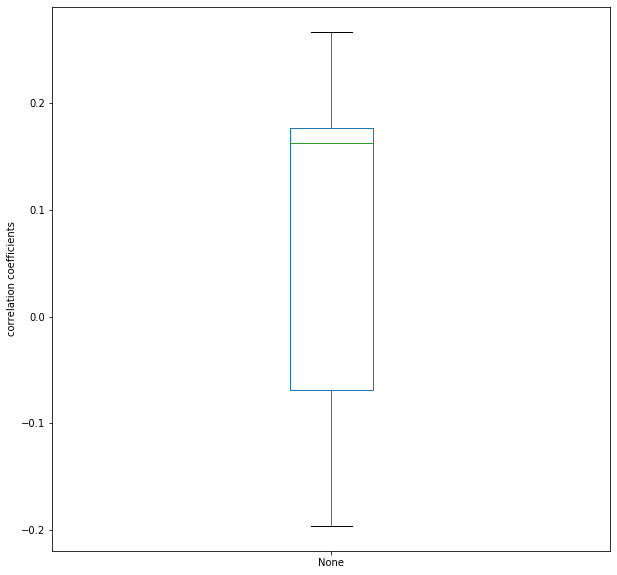

In [83]:
fig,axes = plt.subplots()
pd.Series(cor_list).plot(kind='box', ax=axes)
axes.set_ylabel('correlation coefficients')
axes.set_xlabel('')